In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sentence_transformers import SentenceTransformer, losses, SentencesDataset, InputExample
from torch.utils.data import DataLoader

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split

from datasets import Dataset

from catboost import CatBoostClassifier, Pool
from collections import Counter
import os

d:\!T2-HACK\project\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Подготовка данных

In [2]:
# print(torch.cuda.is_available())
# print(torch.version.cuda)
# print(torch.__version__)

In [3]:
df_employees = pd.read_pickle('dependencies/data/df_employees.pkl')
df_employees.columns

Index(['PERSON_ID', 'SEX', 'CITY', 'GRADE', 'TERMINATION_DATE', 'AGE',
       'MARITAL_STATUS', 'MILITARY_SERVICE_STATUS', 'EDUCATION',
       'VACATION_COUNT_2024', 'LAST_VACATION_DATE', 'COURSES_2024_07',
       'COURSES_2024_08', 'COURSES_2024_09', 'COURSES_2024_10',
       'COURSES_2024_11', 'COURSES_2024_12', 'GR_UP_CHANGE', 'C_C_CHANGE',
       'POS_D_CHANGE', 'MARKS_2020', 'MARKS_2021', 'MARKS_2022', 'MARKS_2023',
       'FULL_SENIORITY', 'GRADE_SENIORITY_LAST', 'AVG_GRADE_SENIORITY',
       'WAS_TRAINEE', 'DAYS_WITHOUT_VALID_REASONS', 'COUNT_BAD_VACATIONS',
       'LAST_BAD_VACATION_DATE', 'ILL_DAYS', 'COUNT_ILL_VACATIONS',
       'LAST_ILLNESS_DATE', 'OPERATION_DATE', 'TERMINATION_REASON',
       'DEPARTMENT', 'TERMINATION_TYPE', 'ACTUAL_BIRTH_DATE',
       'ACTUAL_HIRE_DATE', 'IS_FIRED'],
      dtype='object')

In [4]:
# Убедимся, что даты в datetime формате
df_employees['ACTUAL_BIRTH_DATE'] = pd.to_datetime(df_employees['ACTUAL_BIRTH_DATE'], errors='coerce')
df_employees['ACTUAL_HIRE_DATE'] = pd.to_datetime(df_employees['ACTUAL_HIRE_DATE'], errors='coerce')
df_employees['TERMINATION_DATE'] = pd.to_datetime(df_employees['TERMINATION_DATE'], errors='coerce')

cutoff_date = pd.Timestamp('2024-12-31')

def get_reference_date(row):
    if pd.isna(row['TERMINATION_DATE']):
        return cutoff_date
    if row['TERMINATION_DATE'].year == 2099:
        return cutoff_date
    return row['TERMINATION_DATE']

df_employees['REFERENCE_DATE'] = df_employees.apply(get_reference_date, axis=1)

def calculate_tenure_days(hire_date, ref_date):
    if pd.isna(hire_date) or pd.isna(ref_date):
        return np.nan
    return (ref_date - hire_date).days

def get_actual_seniority(row):
    # Если FULL_SENIORITY есть и больше 0, используем его (в днях)
    if pd.notna(row['FULL_SENIORITY']) and row['FULL_SENIORITY'] > 0:
        return row['FULL_SENIORITY']
    # Иначе считаем по датам (в днях)
    return calculate_tenure_days(row['ACTUAL_HIRE_DATE'], row['REFERENCE_DATE'])

def calculate_age(birth_date, ref_date):
    if pd.isna(birth_date) or pd.isna(ref_date):
        return None
    age = ref_date.year - birth_date.year - ((ref_date.month, ref_date.day) < (birth_date.month, birth_date.day))
    return age

df_employees['ACTUAL_AGE'] = df_employees.apply(lambda row: calculate_age(row['ACTUAL_BIRTH_DATE'], row['REFERENCE_DATE']), axis=1)
df_employees['ACTUAL_SENIORITY'] = df_employees.apply(get_actual_seniority, axis=1)

# Для проверки выводим первые 20 строк
print(df_employees[['PERSON_ID', 'FULL_SENIORITY', 'ACTUAL_HIRE_DATE', 'REFERENCE_DATE', 'ACTUAL_SENIORITY', 'ACTUAL_AGE']].head(500))

     PERSON_ID  FULL_SENIORITY ACTUAL_HIRE_DATE REFERENCE_DATE  \
0         4004          7243.0       2014-01-01     2024-12-31   
1         4008          9921.0       2014-01-01     2024-12-31   
2         4011         10378.0       2014-01-01     2024-12-31   
3         4012          7243.0       2014-01-01     2024-12-31   
4         4015          9769.0       2014-01-01     2024-12-31   
..         ...             ...              ...            ...   
495       8757          5326.0       2012-10-09     2024-12-31   
496       8763          5630.0       2009-08-03     2024-12-31   
497       8768          5661.0       2009-07-01     2024-12-31   
498       8769          4869.0       2023-11-20     2024-12-31   
499       8772          5569.0       2011-09-15     2024-12-31   

     ACTUAL_SENIORITY  ACTUAL_AGE  
0              7243.0          46  
1              9921.0          57  
2             10378.0          55  
3              7243.0          50  
4              9769.0      

In [6]:
cols_to_drop = [
    'PERSON_ID', 'TERMINATION_DATE', 'TERMINATION_REASON', 'TERMINATION_TYPE',
    'LAST_VACATION_DATE', 'LAST_BAD_VACATION_DATE', 'LAST_ILLNESS_DATE', 'OPERATION_DATE',
    'ACTUAL_BIRTH_DATE', 'ACTUAL_HIRE_DATE',
    'GR_UP_CHANGE', 'C_C_CHANGE', 'POS_D_CHANGE',
    'REFERENCE_DATE', 'FULL_SENIORITY',
    'DEPARTMENT', 'CITY'
]

desired_order = [
    'IS_FIRED', 'WAS_TRAINEE', 'SEX', 'AGE', 'ACTUAL_AGE', 'GRADE', 'FULL_SENIORITY',
    'GRADE_SENIORITY_LAST', 'AVG_GRADE_SENIORITY',
    'MARITAL_STATUS', 'MILITARY_SERVICE_STATUS', 'EDUCATION', 
    # 'DEPARTMENT', 'CITY',
    'VACATION_COUNT_2024', 'DAYS_WITHOUT_VALID_REASONS', 'COUNT_BAD_VACATIONS',
    'ILL_DAYS', 'COUNT_ILL_VACATIONS',
    'AVG_MARKS', 'SUM_COURSES_2024',
    # 'MARKS_2020', 'MARKS_2021', 'MARKS_2022', 'MARKS_2023',
    # 'COURSES_2024_07', 'COURSES_2024_08', 'COURSES_2024_09', 'COURSES_2024_10', 'COURSES_2024_11', 'COURSES_2024_12',
]

df_employees_c = df_employees.drop(columns=cols_to_drop)

df_employees_c['AGE'] = df_employees_c['AGE'].fillna(df_employees_c['ACTUAL_AGE'])
df_employees_ohe = df_employees_c.drop('ACTUAL_AGE', axis=1)

df_employees_c['AGE'] = df_employees_c['AGE'].astype(int)
df_employees_c['SEX'] = df_employees_c['SEX'].astype(int)
df_employees_c = df_employees_c.rename(columns={'ACTUAL_SENIORITY': 'FULL_SENIORITY'})

df_employees_c['SUM_COURSES_2024'] = df_employees_c[['COURSES_2024_07', 'COURSES_2024_08', 'COURSES_2024_09', 'COURSES_2024_10', 'COURSES_2024_11', 'COURSES_2024_12']].sum(axis=1)
df_employees_c['AVG_MARKS'] = df_employees_c[['MARKS_2020', 'MARKS_2021', 'MARKS_2022', 'MARKS_2023']].mean(axis=1)

desired_order = [col for col in desired_order if col in df_employees_c.columns]
df_employees_c = df_employees_c[desired_order]
display(df_employees_c.columns.tolist())

['IS_FIRED',
 'WAS_TRAINEE',
 'SEX',
 'AGE',
 'GRADE',
 'FULL_SENIORITY',
 'GRADE_SENIORITY_LAST',
 'AVG_GRADE_SENIORITY',
 'MARITAL_STATUS',
 'MILITARY_SERVICE_STATUS',
 'EDUCATION',
 'VACATION_COUNT_2024',
 'DAYS_WITHOUT_VALID_REASONS',
 'COUNT_BAD_VACATIONS',
 'ILL_DAYS',
 'COUNT_ILL_VACATIONS',
 'AVG_MARKS',
 'SUM_COURSES_2024']

In [16]:
df_employees_ohe = df_employees_c.copy()

# WAS_TRAINEE -> WAS_TRAINEE_BIN, NOT_TRAINEE (0/1)
df_employees_ohe['WAS_TRAINEE'] = df_employees_ohe['WAS_TRAINEE'].str.upper()
df_employees_ohe['WAS_TRAINEE'] = (df_employees_ohe['WAS_TRAINEE'] == 'YES')
df_employees_ohe['NOT_TRAINEE'] = (df_employees_ohe['WAS_TRAINEE'] != 'YES')

# SEX -> MAN, WOMAN (0/1)
df_employees_ohe['MAN'] = (df_employees_ohe['SEX'] == 1).astype(int)
df_employees_ohe['WOMAN'] = (df_employees_ohe['SEX'] == 0).astype(int)

# AGE категории (0/1)
df_employees_ohe['AGE_YOUNG'] = (df_employees_ohe['AGE'] < 30).astype(int)
df_employees_ohe['AGE_MIDDLE'] = ((df_employees_ohe['AGE'] >= 30) & (df_employees_ohe['AGE'] < 45)).astype(int)
df_employees_ohe['AGE_SENIOR'] = (df_employees_ohe['AGE'] >= 45).astype(int)

# GRADE категории (0/1)
df_employees_ohe['GRADE_LOW'] = (df_employees_ohe['GRADE'] < 10).astype(int)
df_employees_ohe['GRADE_MID'] = ((df_employees_ohe['GRADE'] >= 10) & (df_employees_ohe['GRADE'] <= 13)).astype(int)
df_employees_ohe['GRADE_HIGH'] = (df_employees_ohe['GRADE'] >= 14).astype(int)

# FULL_SENIORITY категории (0/1)
df_employees_ohe['SENIORITY_JUNIOR'] = (df_employees_ohe['FULL_SENIORITY'] < 1000).astype(int)
df_employees_ohe['SENIORITY_MIDDLE'] = ((df_employees_ohe['FULL_SENIORITY'] >= 1000) & (df_employees_ohe['FULL_SENIORITY'] <= 3000)).astype(int)
df_employees_ohe['SENIORITY_SENIOR'] = (df_employees_ohe['FULL_SENIORITY'] > 3000).astype(int)

# Пример one-hot для MARITAL_STATUS, MILITARY_SERVICE_STATUS, EDUCATION
marital_dummies = pd.get_dummies(df_employees_ohe['MARITAL_STATUS'], prefix='MARITAL').astype(int)
military_dummies = pd.get_dummies(df_employees_ohe['MILITARY_SERVICE_STATUS'], prefix='MILITARY').astype(int)
education_dummies = pd.get_dummies(df_employees_ohe['EDUCATION'], prefix='EDU').astype(int)

df_employees_ohe = pd.concat([df_employees_ohe, marital_dummies, military_dummies, education_dummies], axis=1)

# Удаляем исходные колонки, если нужно
df_employees_ohe.drop(columns=['WAS_TRAINEE', 'SEX', 'AGE', 'GRADE', 'FULL_SENIORITY', 'MARITAL_STATUS', 'MILITARY_SERVICE_STATUS', 'EDUCATION'], inplace=True)

# Проверяем типы и значения
display(df_employees_ohe.dtypes)
display(df_employees_ohe.head())

IS_FIRED                                                 bool
GRADE_SENIORITY_LAST                                  float64
AVG_GRADE_SENIORITY                                   float64
VACATION_COUNT_2024                                   float64
DAYS_WITHOUT_VALID_REASONS                            float64
COUNT_BAD_VACATIONS                                   float64
ILL_DAYS                                              float64
COUNT_ILL_VACATIONS                                   float64
AVG_MARKS                                             float64
SUM_COURSES_2024                                        int64
NOT_TRAINEE                                              bool
MAN                                                     int64
WOMAN                                                   int64
AGE_YOUNG                                               int64
AGE_MIDDLE                                              int64
AGE_SENIOR                                              int64
GRADE_LO

,IS_FIRED,GRADE_SENIORITY_LAST,AVG_GRADE_SENIORITY,VACATION_COUNT_2024,DAYS_WITHOUT_VALID_REASONS,COUNT_BAD_VACATIONS,ILL_DAYS,COUNT_ILL_VACATIONS,AVG_MARKS,SUM_COURSES_2024,...,MILITARY_Призывник,EDU_Высшее образование - бакалавриат,"EDU_Высшее образование - специалитет, магистратура",EDU_Начальное общее образование,EDU_Начальное профессиональное образование,EDU_Не указано,EDU_Неполное высшее образование,EDU_Основное общее образование,EDU_Среднее общее образование,EDU_Среднее профессиональное образование
0,False,1948.0,2526.50,5.0,0.0,0.0,0.0,0.0,3.375,0,...,0,0,1,0,0,0,0,0,0,0
1,False,1948.0,2526.50,2.0,0.0,0.0,0.0,0.0,3.000,0,...,0,0,1,0,0,0,0,0,0,0
2,False,1948.0,1684.33,3.0,0.0,0.0,0.0,0.0,2.875,0,...,0,0,1,0,0,0,0,0,0,0
3,False,305.0,1684.33,3.0,0.0,0.0,0.0,0.0,3.000,0,...,0,0,1,0,0,0,0,0,0,0
4,False,4017.0,5053.00,5.0,0.0,0.0,16.0,2.0,3.000,0,...,0,0,1,0,0,0,0,0,0,0


In [5]:
df_employees_ohe = pd.read_pickle('df_employees_ohe.pkl')
df_employees_ohe

,IS_FIRED,GRADE_SENIORITY_LAST,AVG_GRADE_SENIORITY,VACATION_COUNT_2024,DAYS_WITHOUT_VALID_REASONS,COUNT_BAD_VACATIONS,ILL_DAYS,COUNT_ILL_VACATIONS,AVG_MARKS,SUM_COURSES_2024,...,EDU_Высшее образование - бакалавриат,"EDU_Высшее образование - специалитет, магистратура",EDU_Начальное общее образование,EDU_Начальное профессиональное образование,EDU_Не указано,EDU_Неполное высшее образование,EDU_Основное общее образование,EDU_Среднее общее образование,EDU_Среднее профессиональное образование,CLUSTER
0,False,1948.0,2526.50,5.0,0.0,0.0,0.0,0.0,3.375,0,...,0,1,0,0,0,0,0,0,0,2
1,False,1948.0,2526.50,2.0,0.0,0.0,0.0,0.0,3.000,0,...,0,1,0,0,0,0,0,0,0,0
2,False,1948.0,1684.33,3.0,0.0,0.0,0.0,0.0,2.875,0,...,0,1,0,0,0,0,0,0,0,2
3,False,305.0,1684.33,3.0,0.0,0.0,0.0,0.0,3.000,0,...,0,1,0,0,0,0,0,0,0,0
4,False,4017.0,5053.00,5.0,0.0,0.0,16.0,2.0,3.000,0,...,0,1,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14847,True,12.0,12.00,0.0,0.0,0.0,0.0,0.0,0.000,4,...,0,0,0,0,0,0,0,0,1,1
14848,True,13.0,13.00,0.0,0.0,0.0,0.0,0.0,0.000,0,...,0,0,0,0,0,0,0,1,0,1
14849,True,11.0,11.00,0.0,0.0,0.0,0.0,0.0,0.000,0,...,1,0,0,0,0,0,0,0,0,1
14850,True,11.0,11.00,1.0,1.0,1.0,0.0,0.0,0.000,0,...,0,0,0,0,0,0,1,0,0,1


In [6]:
def row_to_sentence(row):
    # Формируем список "Заголовок: значение"
    parts = [f"{col}: {row[col]}" for col in df_employees_ohe.columns]
    # Объединяем в одну строку через запятую и пробел
    return ", ".join(parts)

def remove_first_column(text):
    # Разделяем по запятой
    parts = text.split(',')
    # Удаляем первый элемент (IS_FIRED: ...)
    parts_wo_first = parts[1:]
    # Склеиваем обратно в строку
    return ', '.join([p.strip() for p in parts_wo_first])

# Применяем к каждой строке и сохраняем в новый столбец
df_sentences = df_employees_ohe.copy()
df_sentences['ORIGINAL'] = df_sentences.apply(row_to_sentence, axis=1)
df_sentences['DESCRIPTION'] = df_sentences['ORIGINAL'].apply(remove_first_column)

df_batch = df_sentences['DESCRIPTION']
df_batch_list = df_batch.tolist()
texts = df_batch.tolist()
display(len(texts))
display(df_batch.head())

14852

0    GRADE_SENIORITY_LAST: 1948.0, AVG_GRADE_SENIOR...
1    GRADE_SENIORITY_LAST: 1948.0, AVG_GRADE_SENIOR...
2    GRADE_SENIORITY_LAST: 1948.0, AVG_GRADE_SENIOR...
3    GRADE_SENIORITY_LAST: 305.0, AVG_GRADE_SENIORI...
4    GRADE_SENIORITY_LAST: 4017.0, AVG_GRADE_SENIOR...
Name: DESCRIPTION, dtype: object

In [7]:
df_employees_ohe.columns[1:]

Index(['GRADE_SENIORITY_LAST', 'AVG_GRADE_SENIORITY', 'VACATION_COUNT_2024',
       'DAYS_WITHOUT_VALID_REASONS', 'COUNT_BAD_VACATIONS', 'ILL_DAYS',
       'COUNT_ILL_VACATIONS', 'AVG_MARKS', 'SUM_COURSES_2024', 'NOT_TRAINEE',
       'MAN', 'WOMAN', 'AGE_YOUNG', 'AGE_MIDDLE', 'AGE_SENIOR', 'GRADE_LOW',
       'GRADE_MID', 'GRADE_HIGH', 'SENIORITY_JUNIOR', 'SENIORITY_MIDDLE',
       'SENIORITY_SENIOR', 'MARITAL_Вдовец (вдова)', 'MARITAL_Не указано',
       'MARITAL_Никогда не состоял (не состояла в браке)',
       'MARITAL_Разведен (разведена)',
       'MARITAL_Состоит в зарегистрированном браке',
       'MARITAL_Состоит в незарегистрированном браке',
       'MILITARY_Военнообязанный', 'MILITARY_Не указано',
       'MILITARY_Невоеннообязанный', 'MILITARY_Призывник',
       'EDU_Высшее образование - бакалавриат',
       'EDU_Высшее образование - специалитет, магистратура',
       'EDU_Начальное общее образование',
       'EDU_Начальное профессиональное образование', 'EDU_Не указано',
   

# Работа с данными

## Sentence.T

In [9]:
# Загружаем мультиязычную модель, аналог MUSE-3
model_se = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

In [18]:
model_se = SentenceTransformer("dependencies/models/muse/model_se_triplet_3_ohe/")

In [ ]:
# df_batch_embeddings = pd.read_pickle('dependencies/data/df_batch_embeddings_3.pkl')

In [14]:
# Генерируем эмбеддинги для батча текстов
embeddings = model_se.encode(texts, show_progress_bar=True)

# Добавляем эмбеддинги обратно в DataFrame
df_batch_embeddings = df_batch.to_frame()
df_batch_embeddings['embedding'] = embeddings.tolist()

print(df_batch_embeddings.head())

Batches: 100%|██████████| 465/465 [00:13<00:00, 33.62it/s]


                                         DESCRIPTION  \
0  GRADE_SENIORITY_LAST: 1948.0, AVG_GRADE_SENIOR...   
1  GRADE_SENIORITY_LAST: 1948.0, AVG_GRADE_SENIOR...   
2  GRADE_SENIORITY_LAST: 1948.0, AVG_GRADE_SENIOR...   
3  GRADE_SENIORITY_LAST: 305.0, AVG_GRADE_SENIORI...   
4  GRADE_SENIORITY_LAST: 4017.0, AVG_GRADE_SENIOR...   

                                           embedding  
0  [-0.08770125359296799, -0.44096195697784424, -...  
1  [-0.36545830965042114, 0.8715487122535706, -0....  
2  [0.20135025680065155, -0.7562986612319946, -0....  
3  [-0.320736825466156, 0.6380206346511841, -0.55...  
4  [0.30349576473236084, -0.8710396885871887, -0....  


In [16]:
df_batch_embeddings['ORIGINAL'] = df_sentences['ORIGINAL']

In [17]:
df_batch_embeddings

,DESCRIPTION,embedding,ORIGINAL
0,"GRADE_SENIORITY_LAST: 1948.0, AVG_GRADE_SENIOR...","[-0.08770125359296799, -0.44096195697784424, -...","IS_FIRED: False, GRADE_SENIORITY_LAST: 1948.0,..."
1,"GRADE_SENIORITY_LAST: 1948.0, AVG_GRADE_SENIOR...","[-0.36545830965042114, 0.8715487122535706, -0....","IS_FIRED: False, GRADE_SENIORITY_LAST: 1948.0,..."
2,"GRADE_SENIORITY_LAST: 1948.0, AVG_GRADE_SENIOR...","[0.20135025680065155, -0.7562986612319946, -0....","IS_FIRED: False, GRADE_SENIORITY_LAST: 1948.0,..."
3,"GRADE_SENIORITY_LAST: 305.0, AVG_GRADE_SENIORI...","[-0.320736825466156, 0.6380206346511841, -0.55...","IS_FIRED: False, GRADE_SENIORITY_LAST: 305.0, ..."
4,"GRADE_SENIORITY_LAST: 4017.0, AVG_GRADE_SENIOR...","[0.30349576473236084, -0.8710396885871887, -0....","IS_FIRED: False, GRADE_SENIORITY_LAST: 4017.0,..."
...,...,...,...
14847,"GRADE_SENIORITY_LAST: 12.0, AVG_GRADE_SENIORIT...","[0.09522832185029984, 0.11085021495819092, 0.5...","IS_FIRED: True, GRADE_SENIORITY_LAST: 12.0, AV..."
14848,"GRADE_SENIORITY_LAST: 13.0, AVG_GRADE_SENIORIT...","[0.1464802324771881, 0.06545675545930862, 0.53...","IS_FIRED: True, GRADE_SENIORITY_LAST: 13.0, AV..."
14849,"GRADE_SENIORITY_LAST: 11.0, AVG_GRADE_SENIORIT...","[0.14209425449371338, 0.0922284871339798, 0.53...","IS_FIRED: True, GRADE_SENIORITY_LAST: 11.0, AV..."
14850,"GRADE_SENIORITY_LAST: 11.0, AVG_GRADE_SENIORIT...","[0.15799838304519653, 0.07938092947006226, 0.5...","IS_FIRED: True, GRADE_SENIORITY_LAST: 11.0, AV..."


### K-Means

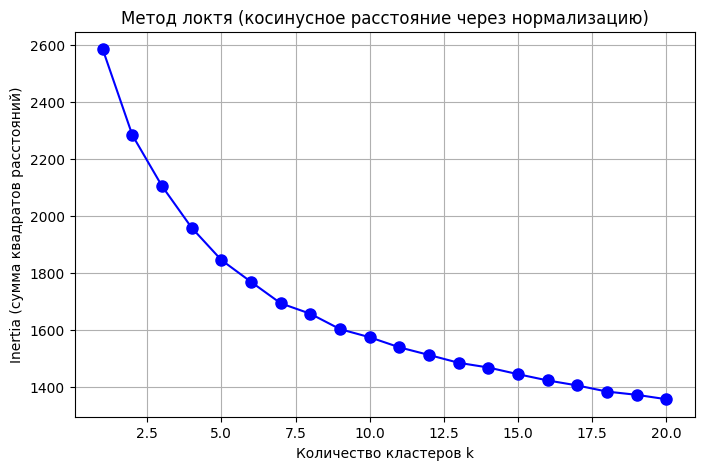

In [22]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# embeddings - массив эмбеддингов
embeddings = np.vstack(df_batch_embeddings['embedding'].values)
embeddings_norm = normalize(embeddings, norm='l2', axis=1)

k_values = range(1, 21)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(embeddings)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, 'bo-', markersize=8)
plt.xlabel('Количество кластеров k')
plt.ylabel('Inertia (сумма квадратов расстояний)')
plt.title('Метод локтя (косинусное расстояние через нормализацию)')
plt.grid(True)
plt.show()

In [19]:
# Предположим, df_batch_embeddings с колонками 'embedding' и 'DESCRIPTION'
embeddings = np.vstack(df_batch_embeddings['embedding'].values)
texts = df_batch_embeddings['DESCRIPTION'].tolist()

# Кластеризация KMeans
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

df_batch_embeddings['cluster'] = labels

# Формируем триплеты на основе кластеров
triplets = []
for cluster_id in range(num_clusters):
    cluster_indices = df_batch_embeddings[df_batch_embeddings['cluster'] == cluster_id].index.tolist()
    other_indices = df_batch_embeddings[df_batch_embeddings['cluster'] != cluster_id].index.tolist()
    
    if len(cluster_indices) < 2 or len(other_indices) == 0:
        continue
    
    for anchor_idx in cluster_indices:
        positive_candidates = [i for i in cluster_indices if i != anchor_idx]
        positive_idx = random.choice(positive_candidates)
        negative_idx = random.choice(other_indices)
        
        anchor_text = df_batch_embeddings.loc[anchor_idx, 'DESCRIPTION']
        positive_text = df_batch_embeddings.loc[positive_idx, 'DESCRIPTION']
        negative_text = df_batch_embeddings.loc[negative_idx, 'DESCRIPTION']

        triplets.append({
            'anchor': anchor_text,
            'positive': positive_text,
            'negative': negative_text
        })

print(f"Сформировано триплетов: {len(triplets)}")

Сформировано триплетов: 14852


### Визуализация кластеров (t-sne)

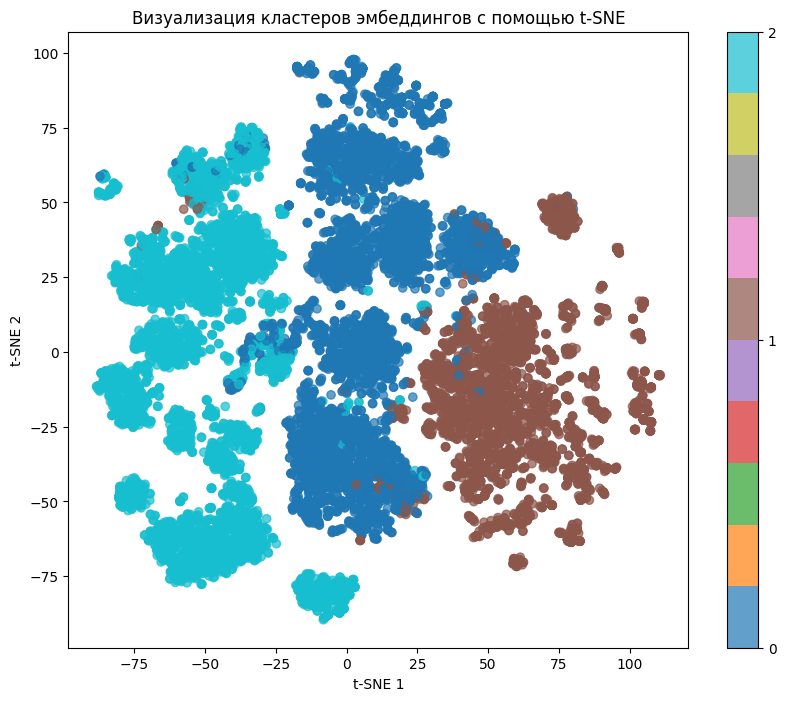

In [24]:
# Применяем t-SNE для снижения размерности до 2D
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Визуализация
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(num_clusters))
plt.title("Визуализация кластеров эмбеддингов с помощью t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

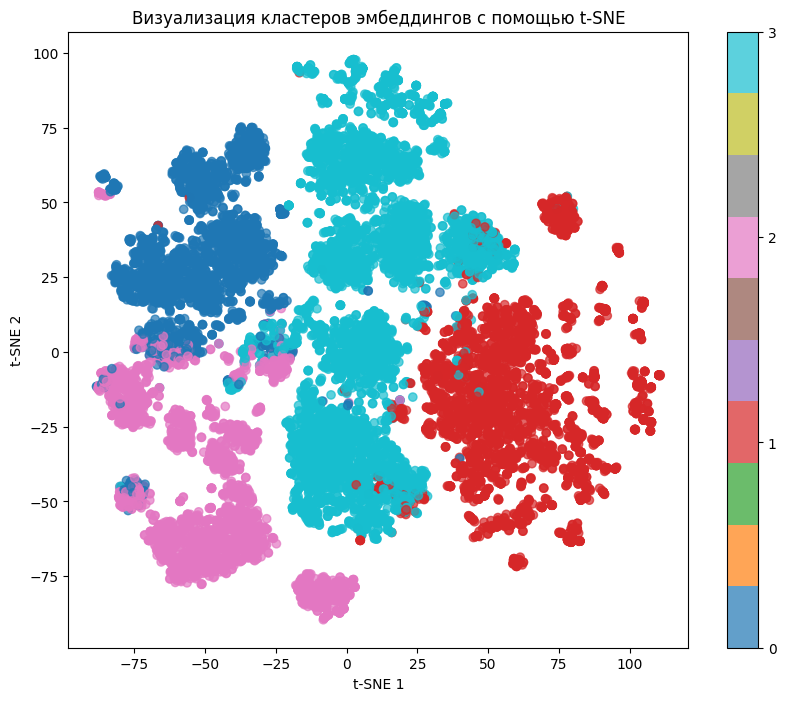

In [31]:
# Разбивка на 4 кластера

In [20]:
df_batch_embeddings

,DESCRIPTION,embedding,ORIGINAL,cluster
0,"GRADE_SENIORITY_LAST: 1948.0, AVG_GRADE_SENIOR...","[-0.08770125359296799, -0.44096195697784424, -...","IS_FIRED: False, GRADE_SENIORITY_LAST: 1948.0,...",1
1,"GRADE_SENIORITY_LAST: 1948.0, AVG_GRADE_SENIOR...","[-0.36545830965042114, 0.8715487122535706, -0....","IS_FIRED: False, GRADE_SENIORITY_LAST: 1948.0,...",0
2,"GRADE_SENIORITY_LAST: 1948.0, AVG_GRADE_SENIOR...","[0.20135025680065155, -0.7562986612319946, -0....","IS_FIRED: False, GRADE_SENIORITY_LAST: 1948.0,...",1
3,"GRADE_SENIORITY_LAST: 305.0, AVG_GRADE_SENIORI...","[-0.320736825466156, 0.6380206346511841, -0.55...","IS_FIRED: False, GRADE_SENIORITY_LAST: 305.0, ...",0
4,"GRADE_SENIORITY_LAST: 4017.0, AVG_GRADE_SENIOR...","[0.30349576473236084, -0.8710396885871887, -0....","IS_FIRED: False, GRADE_SENIORITY_LAST: 4017.0,...",1
...,...,...,...,...
14847,"GRADE_SENIORITY_LAST: 12.0, AVG_GRADE_SENIORIT...","[0.09522832185029984, 0.11085021495819092, 0.5...","IS_FIRED: True, GRADE_SENIORITY_LAST: 12.0, AV...",2
14848,"GRADE_SENIORITY_LAST: 13.0, AVG_GRADE_SENIORIT...","[0.1464802324771881, 0.06545675545930862, 0.53...","IS_FIRED: True, GRADE_SENIORITY_LAST: 13.0, AV...",2
14849,"GRADE_SENIORITY_LAST: 11.0, AVG_GRADE_SENIORIT...","[0.14209425449371338, 0.0922284871339798, 0.53...","IS_FIRED: True, GRADE_SENIORITY_LAST: 11.0, AV...",2
14850,"GRADE_SENIORITY_LAST: 11.0, AVG_GRADE_SENIORIT...","[0.15799838304519653, 0.07938092947006226, 0.5...","IS_FIRED: True, GRADE_SENIORITY_LAST: 11.0, AV...",2


In [29]:
# from mpl_toolkits.mplot3d import Axes3D  # обязательно для 3D-графиков
# import plotly.express as px

# # Применяем t-SNE для снижения размерности до 3D
# tsne = TSNE(n_components=3, perplexity=30, max_iter=1000, random_state=42)
# embeddings_3d = tsne.fit_transform(embeddings)
# color_labels = labels.astype(str) if hasattr(labels, 'astype') else labels

# fig = px.scatter_3d(
#     x=embeddings_3d[:, 0],
#     y=embeddings_3d[:, 1],
#     z=embeddings_3d[:, 2],
#     color=color_labels,  # или просто labels
#     title="3D t-SNE визуализация"
# )
# fig.show(renderer="notebook")

### Обучение

In [38]:
# Создаём Hugging Face Dataset
hf_dataset = Dataset.from_list(triplets)

# Функция для преобразования в InputExample
def to_input_example(example):
    return InputExample(texts=[example['anchor'], example['positive'], example['negative']])

# Преобразуем датасет в список InputExample
input_examples = [to_input_example(ex) for ex in hf_dataset]

# Создаём DataLoader
train_dataloader = DataLoader(input_examples, shuffle=True, batch_size=16)

# Инициализируем TripletLoss
train_loss = losses.TripletLoss(model=model_se)

# Обучение
num_epochs = 4
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)

model_se.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    show_progress_bar=True
)

Step,Training Loss
500,0.879400
1000,0.209500
1500,0.160600
2000,0.117200
2500,0.120300
3000,0.064800
3500,0.058300


In [39]:
# Сохраняем модель на диск
# model_se.save("dependencies/models/muse/model_se_triplet_3")
model_se.save("dependencies/models/muse/model_se_triplet_3_ohe")
# model_se = SentenceTransformer("dependencies/models/muse/model_se_triplet_3")

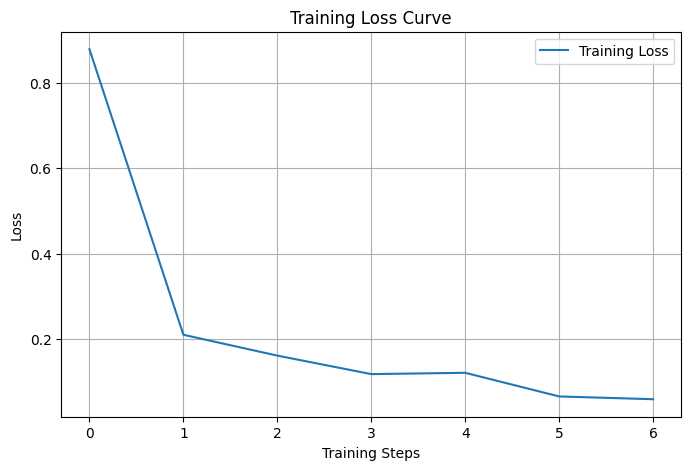

In [40]:
model_losses = [1.098300, 0.227800, 0.172600, 0.147500, 0.136600]
model_losses = [1.605700, 0.579300, 0.425800, 0.318000, 0.266500, 0.202500, 0.168600]
# 2 кластера
model_losses = [1.162100, 0.465700, 0.368500, 0.315900, 0.216400, 0.156500, 0.137100]
model_losses = [1.348200, 0.477000, 0.377600, 0.308600, 0.210900, 0.168200, 0.146600]
model_losses = [0.557000, 0.202700, 0.189400, 0.155700, 0.117500, 0.094800, 0.067900]
model_losses = [0.879400, 0.209500, 0.160600, 0.117200, 0.120300, 0.064800, 0.058300]

plt.figure(figsize=(8,5))
plt.plot(model_losses, label='Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

Batches: 100%|██████████| 233/233 [00:12<00:00, 17.99it/s]
d:\!T2-HACK\project\env\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


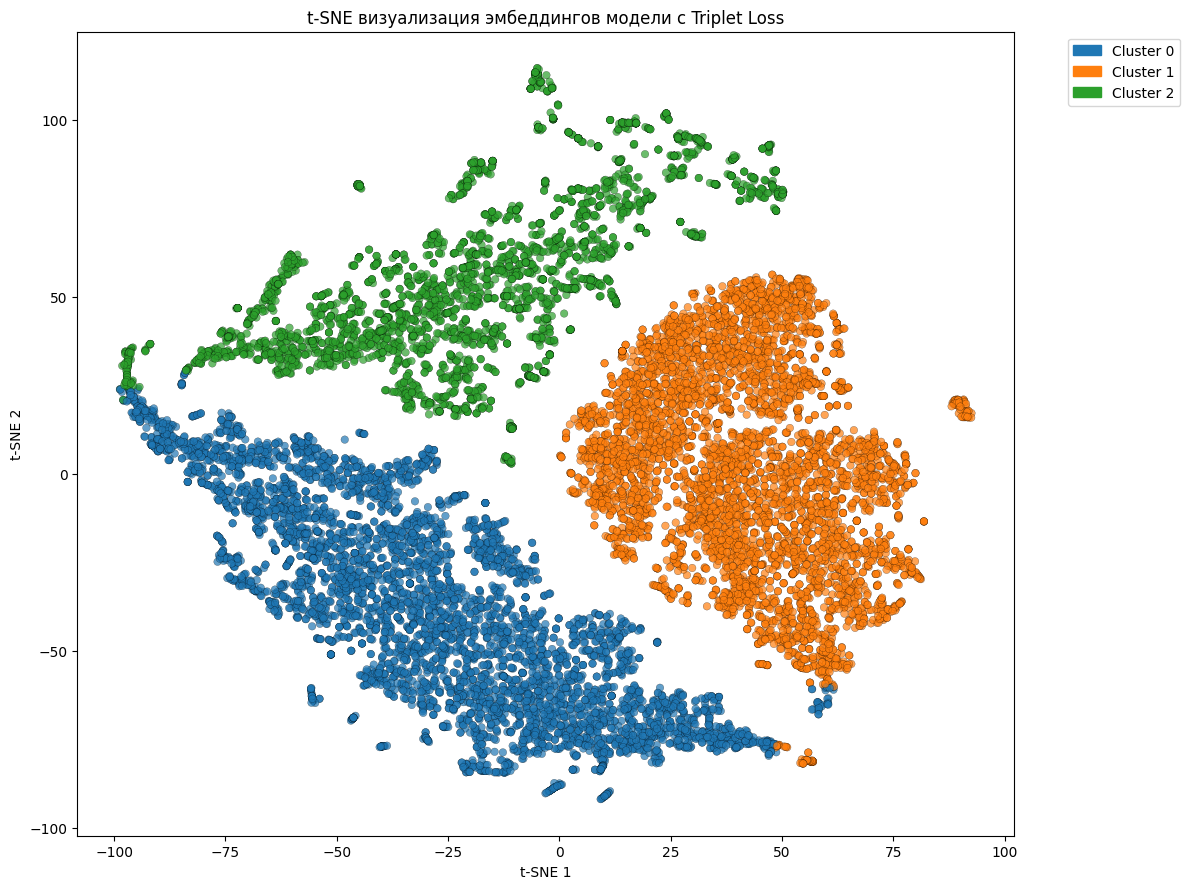

In [21]:
# 1. Получаем эмбеддинги с обученной моделью
texts = df_batch_embeddings['DESCRIPTION'].tolist()
embeddings = model_se.encode(texts, show_progress_bar=True, batch_size=64)
df_batch_embeddings['embeddings_triplet'] = embeddings.tolist()

# 2. Применяем t-SNE
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# 3. Получаем метки кластеров для раскраски (предполагается, что они есть)
cluster_labels = df_batch_embeddings['cluster'].values
unique_labels = np.unique(cluster_labels)

# 4. Создаем палитру цветов (учитываем шум, если есть -1)
num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
palette = sns.color_palette('tab10', n_colors=num_clusters)

colors = []
for label in cluster_labels:
    if label == -1:
        colors.append((0.5, 0.5, 0.5))  # серый для шума
    else:
        colors.append(palette[label % num_clusters])

# 5. Визуализация
plt.figure(figsize=(12, 9))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, alpha=0.7, s=30, edgecolors='k', linewidth=0.2)
plt.title('t-SNE визуализация эмбеддингов модели с Triplet Loss')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

# Легенда
import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=palette[i], label=f'Cluster {i}') for i in range(num_clusters)]
if -1 in unique_labels:
    handles.append(mpatches.Patch(color=(0.5, 0.5, 0.5), label='Noise'))

plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [22]:
from sklearn.metrics.pairwise import cosine_distances

emb_mode = 'embeddings_triplet'

# Убедимся, что embeddings в формате numpy.array
df_batch_embeddings[emb_mode] = df_batch_embeddings[emb_mode].apply(lambda x: np.array(x))

# Вычисляем центроиды по кластерам
centroids = {}
for cluster_id, group in df_batch_embeddings.groupby('cluster'):
    emb_matrix = np.vstack(group[emb_mode].values)
    centroid = emb_matrix.mean(axis=0)
    centroids[cluster_id] = centroid

# Функция для получения N ближайших точек к центроиду
def get_nearest_points_with_texts(cluster_id, N=5):
    group = df_batch_embeddings[df_batch_embeddings['cluster'] == cluster_id]
    emb_matrix = np.vstack(group[emb_mode].values)
    centroid = centroids[cluster_id].reshape(1, -1)
    
    # Косинусное расстояние (1 - косинусная схожесть)
    distances = cosine_distances(emb_matrix, centroid).reshape(-1)
    nearest_idx = distances.argsort()[:N]
    nearest_points = group.iloc[nearest_idx]

    texts = nearest_points['DESCRIPTION'].tolist()
    return texts

for i in range(3):
    nearest_texts = get_nearest_points_with_texts(i, N=5)

    print(f'Cluster: {i}')
    for i, text in enumerate(nearest_texts, 1):
        print(f"{i}. {text}\n")

Cluster: 0
1. GRADE_SENIORITY_LAST: 1056.0, AVG_GRADE_SENIORITY: 0.0, VACATION_COUNT_2024: 3.0, DAYS_WITHOUT_VALID_REASONS: 0.0, COUNT_BAD_VACATIONS: 0.0, ILL_DAYS: 0.0, COUNT_ILL_VACATIONS: 0.0, AVG_MARKS: 0.0, SUM_COURSES_2024: 0, NOT_TRAINEE: True, MAN: 1, WOMAN: 0, AGE_YOUNG: 0, AGE_MIDDLE: 1, AGE_SENIOR: 0, GRADE_LOW: 1, GRADE_MID: 0, GRADE_HIGH: 0, SENIORITY_JUNIOR: 0, SENIORITY_MIDDLE: 1, SENIORITY_SENIOR: 0, MARITAL_Вдовец (вдова): 0, MARITAL_Не указано: 0, MARITAL_Никогда не состоял (не состояла в браке): 0, MARITAL_Разведен (разведена): 0, MARITAL_Состоит в зарегистрированном браке: 1, MARITAL_Состоит в незарегистрированном браке: 0, MILITARY_Военнообязанный: 0, MILITARY_Не указано: 1, MILITARY_Невоеннообязанный: 0, MILITARY_Призывник: 0, EDU_Высшее образование - бакалавриат: 0, EDU_Высшее образование - специалитет, магистратура: 0, EDU_Начальное общее образование: 0, EDU_Начальное профессиональное образование: 0, EDU_Не указано: 1, EDU_Неполное высшее образование: 0, EDU_Осн

In [23]:
from sklearn.metrics import silhouette_score

embeddings = np.vstack(df_batch_embeddings[emb_mode].values)
labels = df_batch_embeddings['cluster'].values

# Для оценки кластеров:
score = silhouette_score(embeddings, labels, metric='cosine')
print(f'Silhouette score для текущей кластеризации: {score}')

Silhouette score для текущей кластеризации: 0.9552635318323206


In [ ]:
'''
Интерпретация кластеров
  Кластер 0 (не очень опытные, но стабильные сотрудники с низкой активностью по отпускам)
  Сотрудники с относительно низкой производительностью и стажем, которые при этом не уволены и берут мало отпусков - возможно, это стабильная, но менее опытная группа.
  
  Кластер 1 (наиболее опытные и продуктивные сотрудники)
  Это группа опытных и продуктивных сотрудников с высоким уровнем квалификации и стажа.
  
  Кластер 2 (сотрудники с проблемами посещаемости и риском увольнения.)
  Cотрудники с нестабильной ситуацией - средним или низким стажем, возможными проблемами с посещаемостью и риском увольнения.
'''

In [47]:
df_employees_ohe.columns

Index(['IS_FIRED', 'GRADE_SENIORITY_LAST', 'AVG_GRADE_SENIORITY',
       'VACATION_COUNT_2024', 'DAYS_WITHOUT_VALID_REASONS',
       'COUNT_BAD_VACATIONS', 'ILL_DAYS', 'COUNT_ILL_VACATIONS', 'AVG_MARKS',
       'SUM_COURSES_2024', 'NOT_TRAINEE', 'MAN', 'WOMAN', 'AGE_YOUNG',
       'AGE_MIDDLE', 'AGE_SENIOR', 'GRADE_LOW', 'GRADE_MID', 'GRADE_HIGH',
       'SENIORITY_JUNIOR', 'SENIORITY_MIDDLE', 'SENIORITY_SENIOR',
       'MARITAL_Вдовец (вдова)', 'MARITAL_Не указано',
       'MARITAL_Никогда не состоял (не состояла в браке)',
       'MARITAL_Разведен (разведена)',
       'MARITAL_Состоит в зарегистрированном браке',
       'MARITAL_Состоит в незарегистрированном браке',
       'MILITARY_Военнообязанный', 'MILITARY_Не указано',
       'MILITARY_Невоеннообязанный', 'MILITARY_Призывник',
       'EDU_Высшее образование - бакалавриат',
       'EDU_Высшее образование - специалитет, магистратура',
       'EDU_Начальное общее образование',
       'EDU_Начальное профессиональное образование', 'E

In [24]:
cluster_0 = df_batch_embeddings[df_batch_embeddings['cluster'] == 0]['ORIGINAL'].tolist()
cluster_1 = df_batch_embeddings[df_batch_embeddings['cluster'] == 1]['ORIGINAL'].tolist()
cluster_2 = df_batch_embeddings[df_batch_embeddings['cluster'] == 2]['ORIGINAL'].tolist()

all_clusters = [cluster_0, cluster_1, cluster_2]

is_fired = {
    '0': [],
    '1': [],
    '2': [],
    '3': [],
}

for i, cl in enumerate(all_clusters):
    for row in cl:
        data = row.split(',')[0].split(' ')[1]
        is_fired[f'{i}'].append(data)
    
# is_fired

{'0': ['False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'True',
  'True',
  'False',
  'False',
  'False',
  'False',
  'True',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'True',
  'False',
  'False',
  'False',
  'False'

In [25]:
display(pd.DataFrame(is_fired['0']).value_counts())
display(pd.DataFrame(is_fired['1']).value_counts())
display(pd.DataFrame(is_fired['2']).value_counts())

0    
False    4265
True     1427
Name: count, dtype: int64

0    
False    4554
True      818
Name: count, dtype: int64

0    
False    2656
True     1132
Name: count, dtype: int64

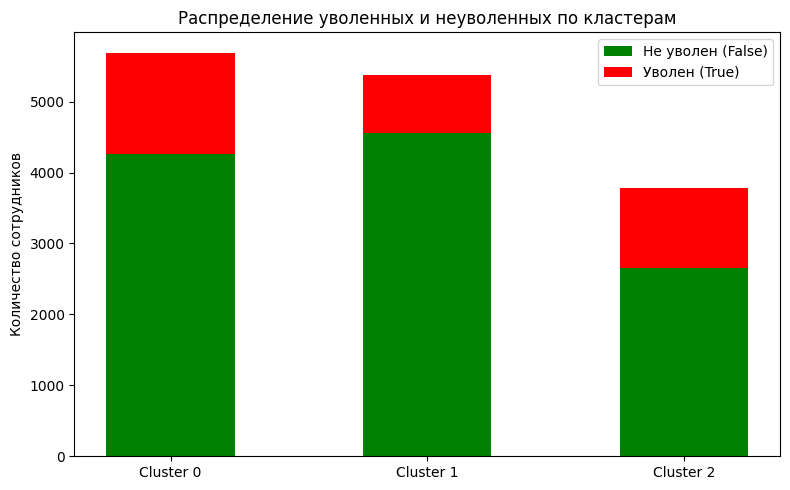

In [26]:
# clusters = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
# not_fired_counts = [2336, 3488, 3740, 1911]
# fired_counts = [43, 2475, 821, 38]

clusters = ['Cluster 0', 'Cluster 1', 'Cluster 2']
not_fired_counts = [4265, 4554, 2656]
fired_counts = [1427, 818, 1132]

x = np.arange(len(clusters))
bar_width = 0.5

plt.figure(figsize=(8, 5))
plt.bar(x, not_fired_counts, width=bar_width, label='Не уволен (False)', color='green')
plt.bar(x, fired_counts, width=bar_width, bottom=not_fired_counts, label='Уволен (True)', color='red')

plt.xticks(x, clusters)
plt.ylabel('Количество сотрудников')
plt.title('Распределение уволенных и неуволенных по кластерам')
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
df_employees_ohe['CLUSTER'] = df_batch_embeddings['cluster']
display(df_employees_ohe.columns)

Index(['IS_FIRED', 'GRADE_SENIORITY_LAST', 'AVG_GRADE_SENIORITY',
       'VACATION_COUNT_2024', 'DAYS_WITHOUT_VALID_REASONS',
       'COUNT_BAD_VACATIONS', 'ILL_DAYS', 'COUNT_ILL_VACATIONS', 'AVG_MARKS',
       'SUM_COURSES_2024', 'NOT_TRAINEE', 'MAN', 'WOMAN', 'AGE_YOUNG',
       'AGE_MIDDLE', 'AGE_SENIOR', 'GRADE_LOW', 'GRADE_MID', 'GRADE_HIGH',
       'SENIORITY_JUNIOR', 'SENIORITY_MIDDLE', 'SENIORITY_SENIOR',
       'MARITAL_Вдовец (вдова)', 'MARITAL_Не указано',
       'MARITAL_Никогда не состоял (не состояла в браке)',
       'MARITAL_Разведен (разведена)',
       'MARITAL_Состоит в зарегистрированном браке',
       'MARITAL_Состоит в незарегистрированном браке',
       'MILITARY_Военнообязанный', 'MILITARY_Не указано',
       'MILITARY_Невоеннообязанный', 'MILITARY_Призывник',
       'EDU_Высшее образование - бакалавриат',
       'EDU_Высшее образование - специалитет, магистратура',
       'EDU_Начальное общее образование',
       'EDU_Начальное профессиональное образование', 'E

## Дерево решений

In [28]:
candidate_rules = [
    # Кластер 0
    ("MAN == 1 and AGE_MIDDLE == 1 and GRADE_LOW == 1", 
     lambda x: (x['MAN'] == 1) and (x['AGE_MIDDLE'] == 1) and (x['GRADE_LOW'] == 1)),
    ("COUNT_BAD_VACATIONS > 0", lambda x: x['COUNT_BAD_VACATIONS'] > 0),
    ("SUM_COURSES_2024 > 5", lambda x: x['SUM_COURSES_2024'] > 5),

    # Кластер 1
    ("WOMAN == 1 and AGE_YOUNG == 1 and GRADE_LOW == 1 and SENIORITY_JUNIOR == 1",
     lambda x: (x['WOMAN'] == 1) and (x['AGE_YOUNG'] == 1) and (x['GRADE_LOW'] == 1) and (x['SENIORITY_JUNIOR'] == 1)),
    ("EDU_Среднее профессиональное образование == 1", lambda x: x.get('EDU_Среднее профессиональное образование', 0) == 1),
    ("SUM_COURSES_2024 > 0", lambda x: x['SUM_COURSES_2024'] > 0),
    ("COUNT_BAD_VACATIONS > 0", lambda x: x['COUNT_BAD_VACATIONS'] > 0),

    # Кластер 2
    ("(MAN == 1 or WOMAN == 1) and EDU_Высшее образование - специалитет, магистратура == 1 and (SENIORITY_SENIOR == 1 or SENIORITY_MIDDLE == 1)",
     lambda x: ((x['MAN'] == 1 or x['WOMAN'] == 1) and 
                (x.get('EDU_Высшее образование - специалитет, магистратура', 0) == 1) and 
                (x['SENIORITY_SENIOR'] == 1 or x['SENIORITY_MIDDLE'] == 1))),
    ("GRADE_MID == 1 or GRADE_LOW == 1", lambda x: (x['GRADE_MID'] == 1 or x['GRADE_LOW'] == 1)),
    ("AVG_MARKS >= 2.5", lambda x: x['AVG_MARKS'] >= 2.5),
    ("ILL_DAYS > 0", lambda x: x['ILL_DAYS'] > 0),
    ("COUNT_BAD_VACATIONS > 0", lambda x: x['COUNT_BAD_VACATIONS'] > 0),
]

In [29]:
# Функции для расчёта критерия Джини и прироста
def gini(y):
    probs = y.value_counts(normalize=True)
    return 1 - np.sum(probs**2)

def gini_gain(y, y_left, y_right):
    parent = gini(y)
    return parent - (len(y_left)/len(y)) * gini(y_left) - (len(y_right)/len(y)) * gini(y_right)

# Поиск лучшего правила для разбиения
def best_split(X, y, rules):
    best_gain = -1
    best_rule = None
    best_mask = None
    best_rule_fn = None
    for name, rule_fn in rules:
        mask = X.apply(rule_fn, axis=1)
        if mask.sum() == 0 or mask.sum() == len(X):
            continue
        gain = gini_gain(y, y[mask], y[~mask])
        if gain > best_gain:
            best_gain = gain
            best_rule = name
            best_rule_fn = rule_fn
            best_mask = mask
    return best_rule, best_rule_fn, best_mask

# Рекурсивное построение дерева
def build_tree(X, y, rules, depth=3):
    if depth == 0 or y.nunique() == 1:
        return y.mode().iloc[0]

    rule, rule_fn, mask = best_split(X, y, rules)
    if rule is None:
        return y.mode().iloc[0]

    return {
        'rule': rule,
        'rule_fn': rule_fn,
        'left': build_tree(X[mask], y[mask], rules, depth-1),
        'right': build_tree(X[~mask], y[~mask], rules, depth-1)
    }

# Предсказание для одной строки
def predict(tree, row):
    if not isinstance(tree, dict):
        return tree
    if tree['rule_fn'](row):
        return predict(tree['left'], row)
    else:
        return predict(tree['right'], row)

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Предположим, df - ваш датафрейм, 'CLUSTER' - целевая переменная
target = 'CLUSTER'
X = df_employees_ohe.drop(columns=[target])
y = df_employees_ohe[target]

# Разбиваем на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Строим дерево на обучающей выборке
tree = build_tree(X_train, y_train, candidate_rules, depth=3)

# Функция для предсказания на всем датафрейме
def predict_df(tree, X):
    return X.apply(lambda row: predict(tree, row), axis=1)

# Предсказания на тесте
y_pred = predict_df(tree, X_test)

# Вычисляем метрики
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

Accuracy: 0.507
Precision: 0.506
Recall: 0.545
F1-score: 0.472


## CatBoost

## Feature по отделам

In [215]:
# from catboost import Pool
# import matplotlib.pyplot as plt
# import pandas as pd

# def plot_feature_importance(model, pool, feature_names, threshold=0.2):
#     importances = model.get_feature_importance(data=pool, type='FeatureImportance')
#     df_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
#     df_imp = df_imp.sort_values('Importance', ascending=False)  # Сортируем по убыванию

#     # Отбираем признаки с важностью выше порога
#     df_imp_filtered = df_imp[df_imp['Importance'] >= threshold]

#     plt.figure(figsize=(10, 8))
#     plt.barh(df_imp_filtered['Feature'], df_imp_filtered['Importance'], color='skyblue')
#     plt.xlabel('Importance Score')
#     plt.title('Feature Importance (>= {})'.format(threshold))
#     plt.tight_layout()
#     plt.show()

# def predict_and_plot_by_department(df_ohe_with_dept, df_ohe, model, cat_features, department_col='DEPARTMENT'):
#     feature_names_model = model.feature_names_  # Признаки модели
#     departments = df_ohe_with_dept[department_col].unique()

#     for dept in departments:
#         print(f"\nОтдел: {dept}")
#         # Индексы сотрудников отдела
#         dept_indices = df_ohe_with_dept[df_ohe_with_dept[department_col] == dept].index

#         # Берём из df_ohe только эти сотрудники и признаки модели
#         X_dept = df_ohe.loc[dept_indices, feature_names_model]

#         if X_dept.empty:
#             print("  Нет данных для этого отдела.")
#             continue

#         pool = Pool(X_dept, cat_features=cat_features)

#         preds = model.predict(pool)
#         probs = model.predict_proba(pool)[:, 1]

#         print(f"  Кол-во сотрудников: {len(X_dept)}")
#         print(f"  Пример вероятностей увольнения: {probs[:5]}")

#         #plot_feature_importance(model, pool, feature_names_model)
#         importances = model.get_feature_importance(data=pool, type='FeatureImportance')

#         if len(feature_names_model) != len(importances):
#             print("Ошибка: длина признаков и важностей не совпадает. Пропускаем визуализацию для этого отдела.")
#             continue

#         df_importance = pd.DataFrame({
#             'Feature': feature_names_model,
#             'Importance': importances
#         })

#         df_importance = df_importance.sort_values('Importance', ascending=True)

#         df_importance_filtered = df_importance[df_importance['Importance'] >= 2]

#         plt.figure(figsize=(10, 8))
#         plt.barh(df_importance_filtered['Feature'], df_importance_filtered['Importance'], color='skyblue')
#         plt.xlabel('Importance Score')
#         plt.title(f'Feature Importance для отдела: {dept}')
#         plt.tight_layout()
#         plt.show()

import shap
import matplotlib.pyplot as plt
import pandas as pd
from catboost import Pool
import numpy as np
def shap_summary_by_department(df_ohe_with_dept, df_ohe, model, cat_features, threshold=0.2, department_col='DEPARTMENT', save_dir='shap_plots'):
    feature_names_model = model.feature_names_
    departments = df_ohe_with_dept[department_col].unique()

    explainer = shap.TreeExplainer(model)

    # Создаём папку для сохранения, если её нет
    os.makedirs(save_dir, exist_ok=True)

    for dept in departments:
        print(f"\nОтдел: {dept}")
        dept_indices = df_ohe_with_dept[df_ohe_with_dept[department_col] == dept].index
        X_dept = df_ohe.loc[dept_indices, feature_names_model]

        if X_dept.empty:
            print("  Нет данных для этого отдела.")
            continue

        pool = Pool(X_dept, cat_features=cat_features)

        shap_values = explainer.shap_values(pool)

        if isinstance(shap_values, list):
            shap_vals = shap_values[1]
        else:
            shap_vals = shap_values

        mean_abs_shap = np.abs(shap_vals).mean(axis=0)
        df_shap = pd.DataFrame({
            'Feature': feature_names_model,
            'MeanAbsSHAP': mean_abs_shap
        })

        df_shap_filtered = df_shap[df_shap['MeanAbsSHAP'] >= threshold]
        selected_features = df_shap_filtered['Feature'].tolist()

        if len(selected_features) == 0:
            print(f"  Нет признаков с абсолютным средним SHAP ≥ {threshold}. Пропускаем визуализацию.")
            continue

        print(f"  Кол-во сотрудников: {len(X_dept)}")
        print(f"  Отобрано признаков с SHAP ≥ {threshold}: {len(selected_features)}")

        # Строим summary plot без автоматического показа
        shap.summary_plot(
            shap_vals[:, [feature_names_model.index(f) for f in selected_features]],
            X_dept[selected_features],
            feature_names=selected_features,
            show=False,
            plot_size=(10,6)
        )

        # Сохраняем текущую фигуру в файл
        filename = f"{save_dir}/shap_summary_{dept.replace(' ', '_').replace('/', '_')}.png"
        plt.savefig(filename, bbox_inches='tight')
        plt.close()
        print(f"  График сохранён в {filename}")

In [218]:
df_employees = pd.read_pickle('dependencies/data/df_employees.pkl')

df_employees_ohe_d = df_employees_ohe.copy()
df_employees_ohe_d['DEPARTMENT'] = df_employees['DEPARTMENT']
departments_to_keep = ['Не указано', 'Биллинг и ИТ', 'B2B-Продажи', 'Big Data_x000D_']

# Фильтрация датафрейма по отделам
df_filtered = df_employees_ohe_d[df_employees_ohe_d['DEPARTMENT'].isin(departments_to_keep)].copy()

df_ohe_filtered = df_employees_ohe_d.loc[df_filtered.index]
df_ohe_filtered.columns

# predict_and_plot_by_department(df_employees_ohe_d, df_employees_ohe, catboost_model, cat_features)

shap_summary_by_department(
    df_ohe_with_dept=df_ohe_filtered,
    df_ohe=df_employees_ohe,
    model=catboost_model,
    cat_features=cat_features,
    threshold=0.2,
    department_col='DEPARTMENT',
    save_dir='images/shap'  # Папка для сохранения графиков
)


Отдел: Не указано
  Кол-во сотрудников: 11988
  Отобрано признаков с SHAP ≥ 0.2: 10
  График сохранён в images/shap/shap_summary_Не_указано.png

Отдел: Биллинг и ИТ
  Кол-во сотрудников: 98
  Отобрано признаков с SHAP ≥ 0.2: 7
  График сохранён в images/shap/shap_summary_Биллинг_и_ИТ.png

Отдел: B2B-Продажи
  Кол-во сотрудников: 102
  Отобрано признаков с SHAP ≥ 0.2: 7
  График сохранён в images/shap/shap_summary_B2B-Продажи.png

Отдел: Big Data_x000D_
  Кол-во сотрудников: 20
  Отобрано признаков с SHAP ≥ 0.2: 7
  График сохранён в images/shap/shap_summary_Big_Data_x000D_.png


## Кластеры

In [31]:
df_cluster_0 = df_employees_ohe[df_employees_ohe['CLUSTER'] == 0]
df_cluster_1 = df_employees_ohe[df_employees_ohe['CLUSTER'] == 1]
df_cluster_2 = df_employees_ohe[df_employees_ohe['CLUSTER'] == 2]

all_clusters = [df_cluster_0, df_cluster_1, df_cluster_2] 

In [32]:
df_cluster_0

,IS_FIRED,GRADE_SENIORITY_LAST,AVG_GRADE_SENIORITY,VACATION_COUNT_2024,DAYS_WITHOUT_VALID_REASONS,COUNT_BAD_VACATIONS,ILL_DAYS,COUNT_ILL_VACATIONS,AVG_MARKS,SUM_COURSES_2024,...,EDU_Высшее образование - бакалавриат,"EDU_Высшее образование - специалитет, магистратура",EDU_Начальное общее образование,EDU_Начальное профессиональное образование,EDU_Не указано,EDU_Неполное высшее образование,EDU_Основное общее образование,EDU_Среднее общее образование,EDU_Среднее профессиональное образование,CLUSTER
1,False,1948.0,2526.50,2.0,0.0,0.0,0.0,0.0,3.00,0,...,0,1,0,0,0,0,0,0,0,0
3,False,305.0,1684.33,3.0,0.0,0.0,0.0,0.0,3.00,0,...,0,1,0,0,0,0,0,0,0,0
9,False,3606.0,2526.50,5.0,0.0,0.0,0.0,0.0,3.00,0,...,0,1,0,0,0,0,0,0,0,0
10,False,1948.0,2526.50,3.0,0.0,0.0,0.0,0.0,3.25,0,...,0,1,0,0,0,0,0,0,0,0
17,False,1187.0,599.75,3.0,0.0,0.0,0.0,0.0,0.00,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14819,True,38.0,38.00,0.0,0.0,0.0,0.0,0.0,0.00,7,...,0,0,0,0,0,0,0,1,0,0
14823,True,56.0,56.00,0.0,0.0,0.0,0.0,0.0,0.00,11,...,0,0,0,0,0,0,1,0,0,0
14826,True,41.0,41.00,1.0,10.0,1.0,0.0,0.0,0.00,12,...,0,1,0,0,0,0,0,0,0,0
14838,True,32.0,32.00,1.0,7.0,1.0,0.0,0.0,0.00,12,...,0,0,0,0,0,0,0,0,1,0


In [33]:
# categorical_columns = df_employees_ohe.select_dtypes(include=['object']).columns.tolist()
# categorical_columns

cat_features = []


Обучение общей модели для всех кластеров
Класс 0: 8032, класс 1: 2364, scale_pos_weight=3.40
0:	test: 0.9468855	best: 0.9468855 (0)	total: 4.36ms	remaining: 4.35s
100:	test: 0.9811671	best: 0.9811671 (100)	total: 530ms	remaining: 4.72s
200:	test: 0.9823715	best: 0.9823715 (200)	total: 1.02s	remaining: 4.05s
300:	test: 0.9826971	best: 0.9827924 (253)	total: 1.52s	remaining: 3.54s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.982792389
bestIteration = 253

Shrink model to first 254 iterations.
              precision    recall  f1-score   support

       False       0.98      0.93      0.95      3443
        True       0.80      0.92      0.86      1013

    accuracy                           0.93      4456
   macro avg       0.89      0.93      0.91      4456
weighted avg       0.94      0.93      0.93      4456

ROC AUC: 0.9828
Weighted F1-score: 0.9315
Average Precision (PR AUC): 0.9520


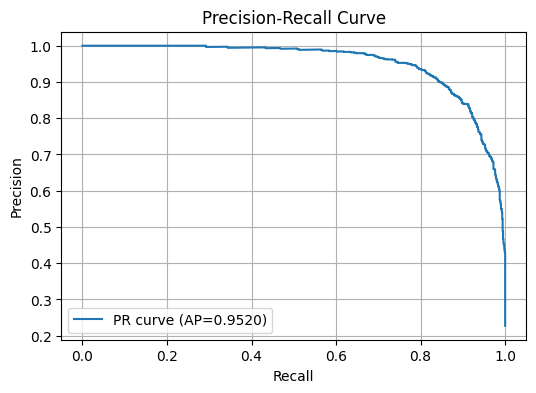

In [38]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import pickle

print(f"\nОбучение общей модели для всех кластеров")

features = df_employees_ohe.drop(columns=['IS_FIRED'])
target = df_employees_ohe['IS_FIRED']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42, stratify=target)

train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1] if 0 in counter and 1 in counter else 1

print(f"Класс 0: {counter.get(0,0)}, класс 1: {counter.get(1,0)}, scale_pos_weight={scale_pos_weight:.2f}")

cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    early_stopping_rounds=50,
    scale_pos_weight=scale_pos_weight,
    verbose=100
)

cb_model.fit(train_pool, eval_set=test_pool, use_best_model=True)

y_pred = cb_model.predict(X_test)
y_proba = cb_model.predict_proba(X_test)[:, 1]

f1_weighted = f1_score(y_test, y_pred, average='weighted')
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

print(classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {auc:.4f}")
print(f"Weighted F1-score: {f1_weighted:.4f}")
print(f"Average Precision (PR AUC): {avg_precision:.4f}")

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'PR curve (AP={avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
import pickle

# Сохранение модели
def save_model(model, filename='dependencies/models/catboost/catboost3_model.cbm'):
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Модель сохранена в {filename}")

# Загрузка модели
def load_model(filename='dependencies/models/catboost/catboost3_model.cbm'):
    with open(filename, 'rb') as f:
        model = pickle.load(f)
    print(f"Модель загружена из {filename}")
    return model

In [254]:
# Пример сохранения
save_model(cb_model)

# Пример загрузки
catboost_model = load_model()

Модель сохранена в dependencies/models/catboost/catboost3_model.cbm
Модель загружена из dependencies/models/catboost/catboost3_model.cbm


In [40]:
import shap
def explain_shap(cb_model, example_df, cat_features):
    pool = Pool(example_df, cat_features=cat_features)
    explainer = shap.TreeExplainer(cb_model)
    shap_values = explainer.shap_values(pool)

    return shap_values

# Текстовое описание усреднённых SHAP значений по батчу
def shap_values_features(shap_values, feature_names, top_k=5):
    feature_impacts = list(zip(feature_names, shap_values))
    feature_impacts.sort(key=lambda x: abs(x[1]), reverse=True)
    lines = []
    for feat, val in feature_impacts[:top_k]:
        direction = "increases" if val > 0 else "decreases"
        lines.append(f"'{feat}', {direction} by {abs(val):.4f}")
    return "\n".join(lines)

# def shap_values_to_text(shap_values, feature_names, features_df, top_k=5):
#     feature_impacts = list(zip(feature_names, shap_values))
#     feature_impacts.sort(key=lambda x: abs(x[1]), reverse=True)
    
#     lines = []
#     for feat, val in feature_impacts[:top_k]:
#         direction = "increases" if val > 0 else "decreases"
#         if feat in features_df.columns:
#             col = features_df[feat]
#             if pd.api.types.is_numeric_dtype(col):
#                 # Для бинарных признаков считаем количество ненулевых
#                 unique_vals = col.dropna().unique()
#                 if set(unique_vals).issubset({0,1}):
#                     count = col.sum()
#                     lines.append(f"Feature values in '{feat}' [count={int(count)}]: {direction} probability of getting fired by {abs(val):.4f}")
#                 else:
#                     mean_val = col.mean()
#                     lines.append(f"Feature values in '{feat}' [mean={mean_val:.2f}]: {direction} probability of getting fired by {abs(val):.4f}")
#             else:
#                 # Если не числовой, просто выводим количество уникальных значений
#                 count = col.count()
#                 lines.append(f"Feature values in '{feat}' [count={count}]: {direction} probability of getting fired by {abs(val):.4f}")
#         else:
#             # Если колонки нет в df, просто выводим без статистики
#             lines.append(f"Feature values in '{feat}' {direction} probability of getting fired by {abs(val):.4f}")

#     return "\n".join(lines)

def shap_values_to_text(shap_values, feature_names, features_df, top_k=5):
    feature_impacts = list(zip(feature_names, shap_values))
    feature_impacts.sort(key=lambda x: abs(x[1]), reverse=True)
    
    lines = []
    for feat, val in feature_impacts[:top_k]:
        direction = "increases" if val > 0 else "decreases"
        if feat in features_df.columns:
            col = features_df[feat]
            if pd.api.types.is_numeric_dtype(col):
                # Для бинарных признаков считаем количество ненулевых
                unique_vals = col.dropna().unique()
                if set(unique_vals).issubset({0,1}):
                    count = col.sum()
                    lines.append(f"'{feat}' [{int(count)}], {direction} by {abs(val):.4f}")
                else:
                    mean_val = col.mean()
                    lines.append(f"'{feat}' [{mean_val:.2f}], {direction} by {abs(val):.4f}")
            else:
                # Если не числовой, просто выводим количество уникальных значений
                count = col.count()
                lines.append(f"'{feat}' [{count}], {direction} by {abs(val):.4f}")
        else:
            # Если колонки нет в df, просто выводим без статистики
            lines.append(f"'{feat}', {direction} by {abs(val):.4f}")

    return "\n".join(lines)


In [219]:
df_batch_embeddings

,DESCRIPTION,embedding,ORIGINAL,cluster,embeddings_triplet
0,"GRADE_SENIORITY_LAST: 1948.0, AVG_GRADE_SENIOR...","[-0.030475366860628128, 0.10140857100486755, 0...","IS_FIRED: False, GRADE_SENIORITY_LAST: 1948.0,...",2,"[-0.08770138025283813, -0.44096171855926514, -..."
1,"GRADE_SENIORITY_LAST: 1948.0, AVG_GRADE_SENIOR...","[-0.05167689174413681, 0.14506110548973083, 0....","IS_FIRED: False, GRADE_SENIORITY_LAST: 1948.0,...",0,"[-0.36545830965042114, 0.871548593044281, -0.4..."
2,"GRADE_SENIORITY_LAST: 1948.0, AVG_GRADE_SENIOR...","[-0.04421088844537735, 0.12281563878059387, 0....","IS_FIRED: False, GRADE_SENIORITY_LAST: 1948.0,...",2,"[0.20135030150413513, -0.7562987804412842, -0...."
3,"GRADE_SENIORITY_LAST: 305.0, AVG_GRADE_SENIORI...","[-0.026596438139677048, 0.12895400822162628, 0...","IS_FIRED: False, GRADE_SENIORITY_LAST: 305.0, ...",0,"[-0.3207368552684784, 0.6380206346511841, -0.5..."
4,"GRADE_SENIORITY_LAST: 4017.0, AVG_GRADE_SENIOR...","[-0.023518012836575508, 0.08159495145082474, -...","IS_FIRED: False, GRADE_SENIORITY_LAST: 4017.0,...",2,"[0.3034957945346832, -0.871039628982544, -0.02..."
...,...,...,...,...,...
14847,"GRADE_SENIORITY_LAST: 12.0, AVG_GRADE_SENIORIT...","[-0.005634772591292858, 0.13300058245658875, 0...","IS_FIRED: True, GRADE_SENIORITY_LAST: 12.0, AV...",1,"[0.0952284038066864, 0.11085021495819092, 0.53..."
14848,"GRADE_SENIORITY_LAST: 13.0, AVG_GRADE_SENIORIT...","[-0.023103192448616028, 0.13045664131641388, 0...","IS_FIRED: True, GRADE_SENIORITY_LAST: 13.0, AV...",1,"[0.14648017287254333, 0.06545686721801758, 0.5..."
14849,"GRADE_SENIORITY_LAST: 11.0, AVG_GRADE_SENIORIT...","[-0.010892931371927261, 0.14778229594230652, 0...","IS_FIRED: True, GRADE_SENIORITY_LAST: 11.0, AV...",1,"[0.14209416508674622, 0.09222856909036636, 0.5..."
14850,"GRADE_SENIORITY_LAST: 11.0, AVG_GRADE_SENIORIT...","[-0.02148435078561306, 0.1450311541557312, 0.1...","IS_FIRED: True, GRADE_SENIORITY_LAST: 11.0, AV...",1,"[0.15799839794635773, 0.07938091456890106, 0.5..."


### Предикт на одного

In [65]:
def predict_employee_status(input_data, 
                            df_reference, 
                            embedding_model, 
                            centroids, 
                            model,
                            cat_features):

    # Функции подготовки текста
    def row_to_sentence(row):
        parts = [f"{col}: {row[col]}" for col in df_reference.columns]
        return ", ".join(parts)

    def remove_first_column(text):
        parts = text.split(',')
        parts_wo_first = parts[1:]
        return ', '.join([p.strip() for p in parts_wo_first])
    
    # Подготовка текста
    original_text = row_to_sentence(input_data)
    description_text = remove_first_column(original_text)
    
    # Получение эмбеддинга
    embedding = embedding_model.encode([description_text])[0]
    
    # Поиск ближайшего кластера
    centroid_embeddings = np.vstack(list(centroids.values()))
    distances = cosine_distances(embedding.reshape(1, -1), centroid_embeddings).reshape(-1)
    nearest_cluster_idx = distances.argmin()
    cluster_id = list(centroids.keys())[nearest_cluster_idx]
    
    # Подготовка признаков для модели
    features = input_data.drop(labels=['IS_FIRED'], errors='ignore')
    example_df = features.to_frame().T
    
    example_pool = Pool(example_df, cat_features=cat_features)
    
    # Предсказания вероятностей и класса
    proba = model.predict_proba(example_pool)[0]
    pred_class = model.predict(example_pool)[0]
    
    # Результат
    result = {
        'cluster_id': cluster_id,
        'distance_to_centroid': distances[nearest_cluster_idx],
        'predicted_class': pred_class,
        'probabilities': {'class_0': proba[0], 'class_1': proba[1]},
        'true_class': input_data.get('IS_FIRED', None),
        'description_text': description_text,
        'example_df' : example_df,
    }
    
    return result

In [66]:
input_id = np.random.randint(0, len(df_employees_ohe))
input_data = df_employees_ohe.iloc[input_id]
description_data = df_batch_embeddings.iloc[input_id]['DESCRIPTION']

shap_df = pd.DataFrame(input_data).T

result = predict_employee_status(
    input_data=input_data,
    df_reference=df_employees_ohe,
    embedding_model=model_se,
    centroids=centroids,
    model=catboost_model,  # передаём одну модель
    cat_features=cat_features
)

shap_values = explain_shap(catboost_model, shap_df, cat_features)
shap_text = shap_values_to_text(shap_values[0], shap_df.columns.tolist())

print(f"Выбранный пример {input_id}")
print(f"Ближайший кластер: {result['cluster_id']} (расстояние {result['distance_to_centroid']:.4f})")
print(f"Вероятности классов: {result['probabilities']}\n")
print(f"Предсказанный класс: {result['predicted_class']}")
print(f"Реальное значение: {result['true_class']}\n")
print(shap_text)

Выбранный пример 7270
Ближайший кластер: 2 (расстояние 0.0051)
Вероятности классов: {'class_0': np.float64(0.9582789710152179), 'class_1': np.float64(0.041721028984782096)}

Предсказанный класс: False
Реальное значение: False

Feature 'MILITARY_Военнообязанный' decreases probabilty of getting fired on 1.0916
Feature 'MAN' increases probabilty of getting fired on 0.9936
Feature 'ILL_DAYS' decreases probabilty of getting fired on 0.9904
Feature 'COUNT_BAD_VACATIONS' decreases probabilty of getting fired on 0.7167
Feature 'MARITAL_Состоит в незарегистрированном браке' decreases probabilty of getting fired on 0.5267


### Предикт по батчам

In [105]:
def predict_batch(input_df, 
                  df_reference, 
                  embedding_model, 
                  centroids, 
                  model, 
                  cat_features, 
                  threshold=0.5):
    results = []
    
    features_df = input_df.drop(columns=['IS_FIRED'], errors='ignore')
    pool = Pool(features_df, cat_features=cat_features)
    
    proba_batch = model.predict_proba(pool)
    
    # Используем порог threshold для предсказания класса
    pred_class_batch = (proba_batch[:, 1] >= threshold).astype(int)
    
    explainer = shap.TreeExplainer(model)
    shap_values_batch = explainer.shap_values(pool)
    mean_shap_values = np.mean(shap_values_batch, axis=0)
    
    for i, (_, row) in enumerate(input_df.iterrows()):
        original_text = ", ".join([f"{col}: {row[col]}" for col in df_reference.columns])
        description_text = ", ".join(original_text.split(',')[1:]).strip()
        embedding = embedding_model.encode([description_text])[0]
        centroid_embeddings = np.vstack(list(centroids.values()))
        distances = cosine_distances(embedding.reshape(1, -1), centroid_embeddings).reshape(-1)
        nearest_cluster_idx = distances.argmin()
        cluster_id = list(centroids.keys())[nearest_cluster_idx]
        
        result = {
            'index': row.name,
            'cluster_id': cluster_id,
            'distance_to_centroid': distances[nearest_cluster_idx],
            'predicted_class': int(pred_class_batch[i]),
            'probabilities': {'class_0': proba_batch[i][0], 'class_1': proba_batch[i][1]},
            'true_class': row.get('IS_FIRED', None),
            'description_text': description_text,
        }
        results.append(result)
    
    return results, mean_shap_values, features_df.columns.tolist()

def visualize_cluster_predictions(output_df, save_path='images/8_prediction_per_claster.png'):
    cluster_pred_counts = output_df.groupby(['CLUSTER', 'PRED']).size().unstack(fill_value=0)
    cluster_pred_counts.columns = ['Stay', 'Fired']

    stay_counts = cluster_pred_counts.get('Stay', pd.Series(0, index=cluster_pred_counts.index))
    fired_counts = cluster_pred_counts.get('Fired', pd.Series(0, index=cluster_pred_counts.index))

    clusters = cluster_pred_counts.index.astype(str)
    total_counts = stay_counts + fired_counts

    x = np.arange(len(clusters))
    bar_width = 0.6

    fig, ax = plt.subplots(figsize=(8,5))

    bars_stay = ax.bar(x, stay_counts, width=bar_width, color='#2ecc71', edgecolor='black', linewidth=1, label='Останутся')
    bars_fired = ax.bar(x, fired_counts, width=bar_width, bottom=stay_counts, color='#e74c3c', edgecolor='black', linewidth=1, label='Уволены')

    ax.set_xticks(x)
    ax.set_xticklabels([f'Кластер {c}\n({total})' for c, total in zip(clusters, total_counts)])
    ax.set_ylabel('Количество сотрудников')
    ax.set_title('Распределение предсказаний по кластерам')
    ax.legend()

    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + height / 2,
                    f'{int(height)}',
                    ha='center',
                    va='center',
                    color='white' if bar.get_facecolor()[:3] == (1.0, 0, 0) else 'black',
                    fontsize=10,
                    fontweight='bold'
                )

    autolabel(bars_stay)
    autolabel(bars_fired)

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()


Всего в батче: 14852
Предсказано останется (class 0): 10982 | Реально осталось: 11475
Предсказано уволится (class 1): 3870 | Реально уволилось: 3377

----------------------------------------

Усреднённые SHAP значения по батчу:
'WOMAN' [8705], decreases by 0.4698
'MAN' [6147], decreases by 0.3036
'VACATION_COUNT_2024' [4.46], decreases by 0.2358
'MILITARY_Не указано' [7044], decreases by 0.1912
'EDU_Не указано' [733], decreases by 0.1298


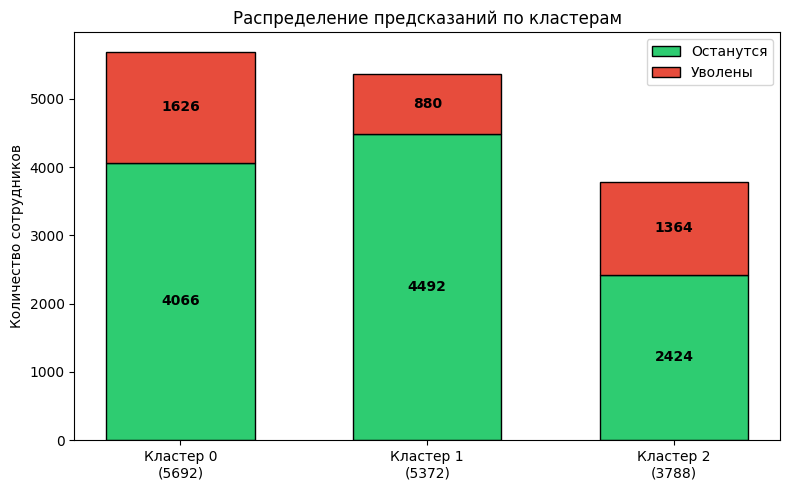


Выборка по сотрудникам:


,IS_FIRED,PROB,PRED,CLUSTER,WOMAN,MAN
0,False,0.09,False,1,1,0
1,False,0.49,False,0,1,0
2,False,0.27,False,1,1,0
3,False,0.18,False,0,1,0
4,False,0.00,False,1,0,1
...,...,...,...,...,...,...
14847,True,0.96,True,2,1,0
14848,True,0.91,True,2,1,0
14849,True,0.99,True,2,1,0
14850,True,0.99,True,2,1,0


In [110]:
input_id = np.random.randint(100, len(df_employees_ohe))
input_data = df_employees_ohe.iloc[input_id-100:input_id]
input_data = df_employees_ohe

results, mean_shap, feature_names = predict_batch(
    input_df=input_data,
    df_reference=df_employees_ohe,
    embedding_model=model_se,
    centroids=centroids,
    model=catboost_model,
    cat_features=cat_features,
    threshold=0.5
)

count_stay = sum(r['predicted_class'] == 0 for r in results)
count_fired = sum(r['predicted_class'] == 1 for r in results)
total = len(results)

true_values = input_data.get('IS_FIRED')
if true_values is not None:
    real_stay = (true_values == 0).sum()
    real_fired = (true_values == 1).sum()
else:
    real_stay = real_fired = None

percent_stay = count_stay / total * 100
percent_fired = count_fired / total * 100

prediction_summary = (
    f"In this group of {total} employees, the model predicts that approximately "
    f"{count_fired} employees ({percent_fired:.1f}%) are likely to be fired, "
    f"while {count_stay} employees ({percent_stay:.1f}%) are likely to stay."
)

predicted_classes = [r['predicted_class'] for r in results]
prob_class_1 = [r['probabilities']['class_1'] for r in results]

output_df = input_data.copy()
output_df['PRED'] = np.array(predicted_classes).astype(bool)
output_df['PROB'] = np.round(prob_class_1, 2)

print(f"Всего в батче: {len(results)}")
print(f"Предсказано останется (class 0): {count_stay} | Реально осталось: {real_stay}")
print(f"Предсказано уволится (class 1): {count_fired} | Реально уволилось: {real_fired}\n")

print('----'*10)
print("\nУсреднённые SHAP значения по батчу:")
features_df = input_data.drop(columns=['IS_FIRED'], errors='ignore')

shap_text = shap_values_to_text(mean_shap, feature_names, features_df, top_k=5)
print(shap_text)

visualize_cluster_predictions(output_df)

print('\nВыборка по сотрудникам:')
display(output_df[['IS_FIRED', 'PROB', 'PRED', 'CLUSTER', 'WOMAN', 'MAN']])

# Стат. тесты

In [125]:
all_clusters[0].columns

Index(['IS_FIRED', 'GRADE_SENIORITY_LAST', 'AVG_GRADE_SENIORITY',
       'VACATION_COUNT_2024', 'DAYS_WITHOUT_VALID_REASONS',
       'COUNT_BAD_VACATIONS', 'ILL_DAYS', 'COUNT_ILL_VACATIONS', 'AVG_MARKS',
       'SUM_COURSES_2024', 'NOT_TRAINEE', 'MAN', 'WOMAN', 'AGE_YOUNG',
       'AGE_MIDDLE', 'AGE_SENIOR', 'GRADE_LOW', 'GRADE_MID', 'GRADE_HIGH',
       'SENIORITY_JUNIOR', 'SENIORITY_MIDDLE', 'SENIORITY_SENIOR',
       'MARITAL_Вдовец (вдова)', 'MARITAL_Не указано',
       'MARITAL_Никогда не состоял (не состояла в браке)',
       'MARITAL_Разведен (разведена)',
       'MARITAL_Состоит в зарегистрированном браке',
       'MARITAL_Состоит в незарегистрированном браке',
       'MILITARY_Военнообязанный', 'MILITARY_Не указано',
       'MILITARY_Невоеннообязанный', 'MILITARY_Призывник',
       'EDU_Высшее образование - бакалавриат',
       'EDU_Высшее образование - специалитет, магистратура',
       'EDU_Начальное общее образование',
       'EDU_Начальное профессиональное образование', 'E

In [269]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def interpret_p_value_one_sided(p, stat, alpha=0.05, direction='greater'):
    if direction == 'greater':
        if stat > 0:
            p_one_sided = p / 2
        else:
            p_one_sided = 1 - p / 2
    else:
        if stat < 0:
            p_one_sided = p / 2
        else:
            p_one_sided = 1 - p / 2
    if p_one_sided < alpha:
        return f"Статистически значимо (p={p_one_sided:.8f}), гипотеза подтверждается"
    else:
        return f"Статистически не значимо (p={p_one_sided:.8f}), гипотеза не подтверждается"

def plot_density_log(sample1, sample2, label1, label2, variable_name):
    plt.figure(figsize=(8,4))
    log_sample1 = np.log1p(sample1)
    log_sample2 = np.log1p(sample2)
    sns.kdeplot(log_sample1, shade=True, label=f"{label1} (log1p)")
    sns.kdeplot(log_sample2, shade=True, label=f"{label2} (log1p)")
    plt.title(f'Плотность распределения логарифмированных значений {variable_name}')
    plt.xlabel(f'log(1 + {variable_name})')
    plt.ylabel('Плотность')
    plt.legend()
    plt.tight_layout()
    plt.show()

def run_one_sided_test_log(sample1, sample2, label1, label2, variable_name, direction='greater'):
    # Логарифмируем данные
    log_sample1 = np.log1p(sample1)
    log_sample2 = np.log1p(sample2)
    
    # Проверка нормальности на логарифмированных данных
    normal1 = (len(log_sample1) >= 3) and (stats.shapiro(log_sample1)[1] > 0.05)
    normal2 = (len(log_sample2) >= 3) and (stats.shapiro(log_sample2)[1] > 0.05)
    
    if normal1 and normal2:
        equal_var = stats.levene(log_sample1, log_sample2)[1] > 0.05
        stat, p = stats.ttest_ind(log_sample1, log_sample2, equal_var=equal_var)
        test_used = "t-test"
    else:
        alternative = 'greater' if direction == 'greater' else 'less'
        stat, p = stats.mannwhitneyu(sample1, sample2, alternative=alternative)
        test_used = "Mann-Whitney U"
    
    print(f"\n{variable_name} ({label1} vs {label2}):")
    print(f"  Тест: {test_used}, stat={stat:.3f}, p(двусторонний)={p if test_used=='Mann-Whitney U' else p*2:.8f}")
    print("  Интерпретация (односторонний тест):", interpret_p_value_one_sided(p if test_used=='Mann-Whitney U' else p*2, stat, direction=direction))
    
    plot_density_log(sample1, sample2, label1, label2, variable_name)

def test_hypothesis_3_one_sided_log(df):
    print("\nГипотеза 3 (односторонние тесты с логарифмированием): Гендерные и возрастные различия в посещаемости и увольнениях (кластер 2)")
    
    df_c2 = df[df['CLUSTER'] == 2]
    if df_c2.empty:
        print("Нет данных для кластера 2")
        return
    
    # 1. ILL_DAYS: женщины > мужчины
    run_one_sided_test_log(
        df_c2[df_c2['WOMAN'] == 1]['ILL_DAYS'],
        df_c2[df_c2['MAN'] == 1]['ILL_DAYS'],
        "женщины", "мужчины", "количество больничных дней (ILL_DAYS)", direction='greater'
    )
    
    # 2. DAYS_WITHOUT_VALID_REASONS: женщины > мужчины
    run_one_sided_test_log(
        df_c2[df_c2['WOMAN'] == 1]['DAYS_WITHOUT_VALID_REASONS'],
        df_c2[df_c2['MAN'] == 1]['DAYS_WITHOUT_VALID_REASONS'],
        "женщины", "мужчины", "количество прогулов (DAYS_WITHOUT_VALID_REASONS)", direction='greater'
    )
    
    # 3. ILL_DAYS: молодые > остальные
    run_one_sided_test_log(
        df_c2[df_c2['AGE_YOUNG'] == 1]['ILL_DAYS'],
        df_c2[df_c2['AGE_YOUNG'] == 0]['ILL_DAYS'],
        "молодые", "остальные", "количество больничных дней (ILL_DAYS)", direction='greater'
    )
    
    # 4. DAYS_WITHOUT_VALID_REASONS: молодые > остальные
    run_one_sided_test_log(
        df_c2[df_c2['AGE_YOUNG'] == 1]['DAYS_WITHOUT_VALID_REASONS'],
        df_c2[df_c2['AGE_YOUNG'] == 0]['DAYS_WITHOUT_VALID_REASONS'],
        "молодые", "остальные", "количество прогулов (DAYS_WITHOUT_VALID_REASONS)", direction='greater'
    )
    

    # 5. Связь пола и увольнения (IS_FIRED) – односторонний тест Фишера
    contingency_gender = pd.crosstab(df_c2['WOMAN'], df_c2['IS_FIRED'])
    if contingency_gender.shape == (2, 2):
        _, p = stats.fisher_exact(contingency_gender, alternative='greater')
        print(f"\nСвязь пола и увольнения (IS_FIRED):")
        print(f"  Тест: Fisher Exact (односторонний), p={p:.8f}")
        if p < 0.05:
            print("  Вывод: Женщины имеют статистически значимо большую вероятность увольнения, чем мужчины.")
        else:
            print("  Вывод: Статистически значимой разницы в вероятности увольнения между женщинами и мужчинами не обнаружено.")
    else:
        print("\nНедостаточно данных для теста связи пола и увольнения.")
    
    # 6. Связь возраста и увольнения (IS_FIRED) – односторонний тест Фишера
    contingency_age = pd.crosstab(df_c2['AGE_YOUNG'], df_c2['IS_FIRED'])
    if contingency_age.shape == (2, 2):
        _, p = stats.fisher_exact(contingency_age, alternative='greater')
        print(f"\nСвязь возраста (молодые vs остальные) и увольнения (IS_FIRED):")
        print(f"  Тест: Fisher Exact (односторонний), p={p:.8f}")
        if p < 0.05:
            print("  Вывод: Молодые сотрудники имеют статистически значимо большую вероятность увольнения, чем остальные.")
        else:
            print("  Вывод: Статистически значимой разницы в вероятности увольнения между молодыми и остальными не обнаружено.")
    else:
        print("\nНедостаточно данных для теста связи возраста и увольнения.")

In [273]:
# c_cluster = all_clusters[2]
# # test_hypothesis_1_with_text(c_cluster)
# # test_hypothesis_2_with_text(c_cluster)
# test_hypothesis_3_one_sided_log(c_cluster)

## Гипотеза 1. 
Сотрудники из кластера 1, состоящие в зарегистрированном браке, имеют статистически значимо меньший риск увольнения по сравнению с остальными сотрудниками этого кластера.

In [307]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

# Выбираем кластер 2
df_c2 = all_clusters[2].copy()

# Пример признаков
features = ['DAYS_WITHOUT_VALID_REASONS', 'ILL_DAYS', 'AVG_MARKS', 'SENIORITY_JUNIOR', 'SENIORITY_MIDDLE', 'SENIORITY_SENIOR', 'MAN', 'WOMAN', 'MARITAL_Состоит в зарегистрированном браке']

X = df_c2[features].fillna(0)

# Кодируем бинарные категориальные признаки, если нужно (зависит от данных)
# Здесь предположим, что они уже бинарные 0/1

y = df_c2['IS_FIRED']

# Масштабируем числовые признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Обучаем логистическую регрессию
model = LogisticRegression(max_iter=1000)
model.fit(X_scaled, y)

# Предсказания и оценка
y_pred_proba = model.predict_proba(X_scaled)[:,1]
auc = roc_auc_score(y, y_pred_proba)
print(f"ROC-AUC модели: {auc:.3f}")

# Коэффициенты и признаки
coef_df = pd.DataFrame({'feature': features, 'coef': model.coef_[0]})
coef_df['odds_ratio'] = np.exp(coef_df['coef'])
print(coef_df.sort_values(by='odds_ratio', ascending=False))

ROC-AUC модели: 0.811
                                      feature      coef  odds_ratio
7                                       WOMAN  0.696415    2.006547
0                  DAYS_WITHOUT_VALID_REASONS  0.305816    1.357732
3                            SENIORITY_JUNIOR  0.126570    1.134929
2                                   AVG_MARKS  0.023625    1.023906
5                            SENIORITY_SENIOR -0.044872    0.956120
4                            SENIORITY_MIDDLE -0.113777    0.892457
8  MARITAL_Состоит в зарегистрированном браке -0.461115    0.630580
6                                         MAN -0.696415    0.498369
1                                    ILL_DAYS -1.020997    0.360236


In [279]:
df_c1 = all_clusters[1].copy()

contingency = pd.crosstab(df_c1['MARITAL_Состоит в зарегистрированном браке'], df_c1['IS_FIRED'])

if contingency.shape == (2, 2):
    _, p = stats.fisher_exact(contingency, alternative='less')
    print(f"p-value для гипотезы о меньшем риске увольнения у сотрудников в зарегистрированном браке: {p:.8f}")
else:
    print("Недостаточно данных для теста")

p-value для гипотезы о меньшем риске увольнения у сотрудников в зарегистрированном браке: 0.00000000


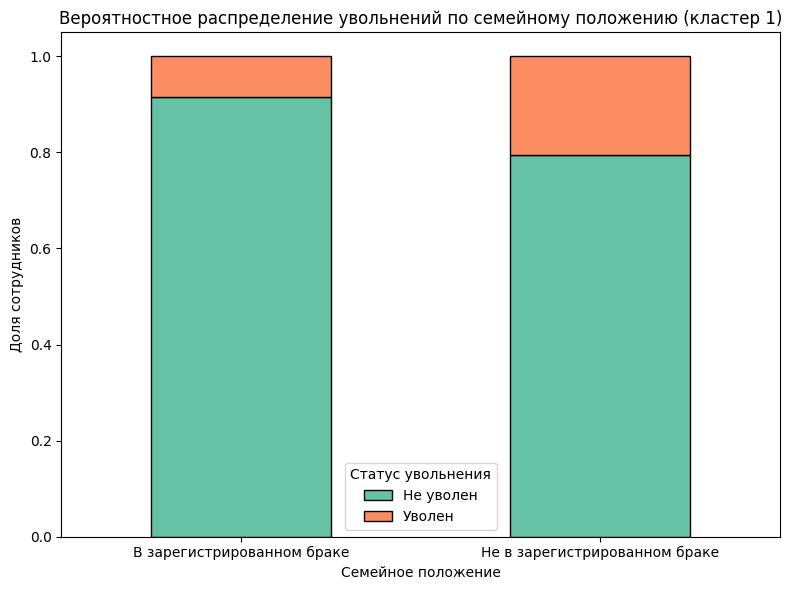

In [300]:
df_c1 = all_clusters[1].copy()

# Создадим колонку с меткой группы: в браке или нет
df_c1['Marital_Status'] = df_c1['MARITAL_Состоит в зарегистрированном браке'].map({1: 'В зарегистрированном браке', 0: 'Не в зарегистрированном браке'})

# Создадим колонку с меткой увольнения
df_c1['Fired_Status'] = df_c1['IS_FIRED'].map({True: 'Уволен', False: 'Не уволен'})

# Считаем количество по группам
group_counts = df_c1.groupby(['Marital_Status', 'Fired_Status']).size().reset_index(name='Count')

# Считаем суммарное количество по каждой группе Marital_Status
total_counts = group_counts.groupby('Marital_Status')['Count'].transform('sum')

# Добавляем колонку с долей (вероятностью) увольнения/неувольнения в группе
group_counts['Proportion'] = group_counts['Count'] / total_counts

# Пивотируем для удобства визуализации
pivot_df = group_counts.pivot(index='Marital_Status', columns='Fired_Status', values='Proportion').fillna(0)

# Строим stacked bar plot с долями
ax = pivot_df.plot(kind='bar', stacked=True, color=['#66c2a5', '#fc8d62'], figsize=(8,6))

# Добавляем тёмную обводку к каждому прямоугольнику
for i, bar_container in enumerate(ax.containers):
    for bar in bar_container:
        bar.set_edgecolor('black')
        bar.set_linewidth(1)

plt.title('Вероятностное распределение увольнений по семейному положению (кластер 1)')
plt.xlabel('Семейное положение')
plt.ylabel('Доля сотрудников')
plt.legend(title='Статус увольнения')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Гипотеза 2.
Военный статус сотрудников влияет на их средний балл (AVG_MARKS) и вероятность увольнения (IS_FIRED). В частности, призывники (MILITARY_Призывник) отличаются по этим показателям от других категорий.

Крускал-Уоллис по AVG_MARKS: stat=655.958, p-value=0.00000000
              Group1             Group2       stat  p_uncorrected  \
4  Невоеннообязанный          Призывник   127147.0   8.178894e-78   
2    Военнообязанный          Призывник   368558.5   5.677645e-72   
3  Невоеннообязанный         Не указано  1154780.5   1.109250e-60   
1    Военнообязанный         Не указано  3195500.5   2.685014e-57   
5         Не указано          Призывник   384736.0   1.545282e-38   
0    Военнообязанный  Невоеннообязанный   592977.0   1.452223e-07   

    p_corrected  reject_null  
4  4.907337e-77         True  
2  3.406587e-71         True  
3  6.655500e-60         True  
1  1.611008e-56         True  
5  9.271695e-38         True  
0  8.713341e-07         True  
Хи-квадрат по IS_FIRED: chi2=216.752, p-value=0.00000000


C:\Users\xgorio\AppData\Local\Temp\ipykernel_12988\1609751377.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Military_Status', y='AVG_MARKS', data=df_military, palette='Set3', inner='quartile')


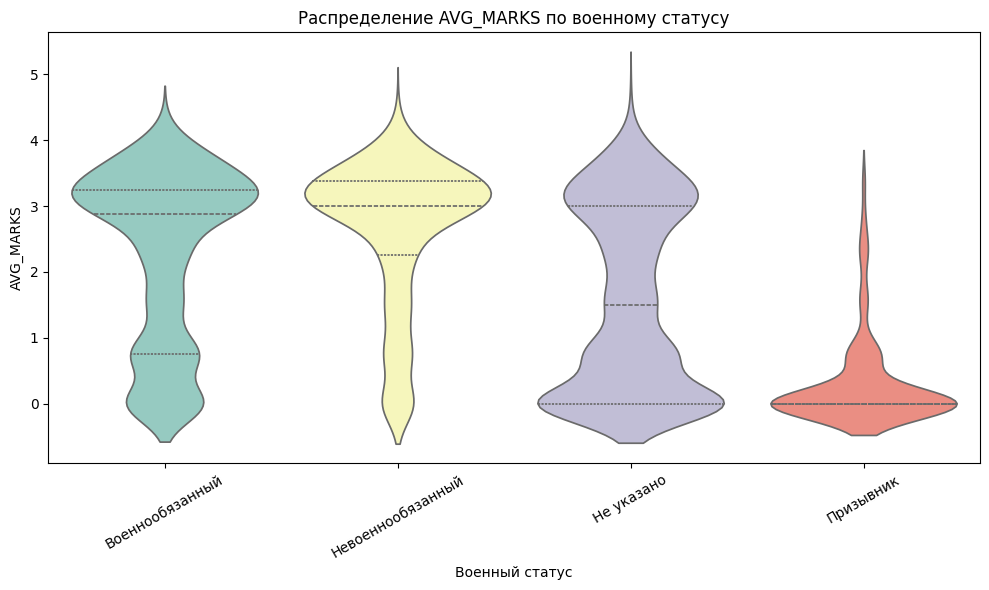

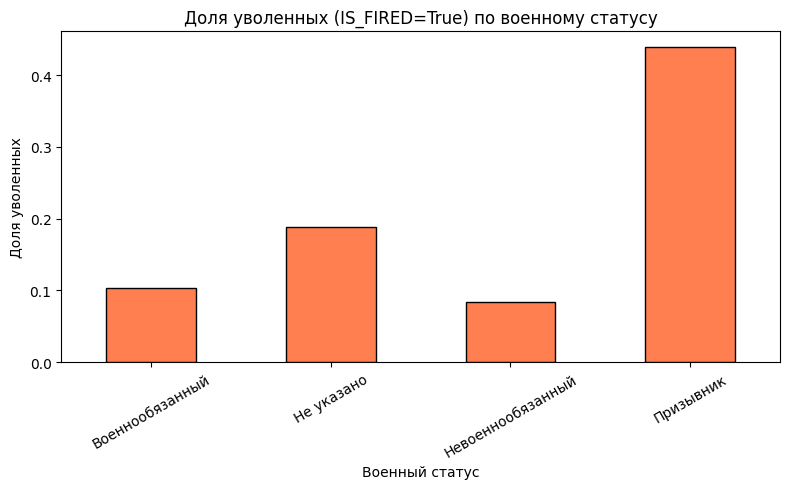

In [336]:
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from statsmodels.stats.multitest import multipletests

df = all_clusters[1].copy()

# Выбираем нужные колонки и удаляем пропуски по AVG_MARKS и MILITARY
df_military = df[['AVG_MARKS', 'IS_FIRED', 'MILITARY_Призывник', 'MILITARY_Военнообязанный', 'MILITARY_Невоеннообязанный', 'MILITARY_Не указано']].dropna()

# Определяем военный статус в одной колонке
def get_military_status(row):
    if row['MILITARY_Призывник'] == 1:
        return 'Призывник'
    elif row['MILITARY_Военнообязанный'] == 1:
        return 'Военнообязанный'
    elif row['MILITARY_Невоеннообязанный'] == 1:
        return 'Невоеннообязанный'
    elif row['MILITARY_Не указано'] == 1:
        return 'Не указано'
    else:
        return 'Другое'

df_military['Military_Status'] = df_military.apply(get_military_status, axis=1)

# Крускал-Уоллис для AVG_MARKS
groups_marks = [group['AVG_MARKS'].values for name, group in df_military.groupby('Military_Status')]
stat, p = stats.kruskal(*groups_marks)
print(f"Крускал-Уоллис по AVG_MARKS: stat={stat:.3f}, p-value={p:.8f}")

# Попарные тесты Манна-Уитни с коррекцией
statuses = df_military['Military_Status'].unique()
pairs = list(itertools.combinations(statuses, 2))
p_values = []
results = []

for g1, g2 in pairs:
    data1 = df_military[df_military['Military_Status'] == g1]['AVG_MARKS']
    data2 = df_military[df_military['Military_Status'] == g2]['AVG_MARKS']
    stat_pair, p_pair = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    p_values.append(p_pair)
    results.append({'Group1': g1, 'Group2': g2, 'stat': stat_pair, 'p_uncorrected': p_pair})

reject, p_corrected, _, _ = multipletests(p_values, method='bonferroni')
for i, res in enumerate(results):
    res['p_corrected'] = p_corrected[i]
    res['reject_null'] = reject[i]

results_df = pd.DataFrame(results)
print(results_df.sort_values('p_corrected'))

# Аналогично сравним IS_FIRED между группами (хи-квадрат)
contingency_table = pd.crosstab(df_military['Military_Status'], df_military['IS_FIRED'])
chi2, p_chi, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Хи-квадрат по IS_FIRED: chi2={chi2:.3f}, p-value={p_chi:.8f}")

# Визуализация распределения AVG_MARKS по военному статусу
plt.figure(figsize=(10,6))
sns.violinplot(x='Military_Status', y='AVG_MARKS', data=df_military, palette='Set3', inner='quartile')
plt.title('Распределение AVG_MARKS по военному статусу')
plt.xlabel('Военный статус')
plt.ylabel('AVG_MARKS')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Построение графика доли уволенных (IS_FIRED == True) по военному статусу
contingency_table_norm = contingency_table.div(contingency_table.sum(axis=1), axis=0)

ax = contingency_table_norm[True].plot(kind='bar', color='coral', edgecolor='black', figsize=(8,5))
plt.title('Доля уволенных (IS_FIRED=True) по военному статусу')
plt.ylabel('Доля уволенных')
plt.xlabel('Военный статус')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# LLM Explainability

In [110]:
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import torch

# Путь к папке с моделью
model_path = "dependencies/models/phi-2"

# Инициализация модели и токенизатора
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
phi_model = AutoModelForCausalLM.from_pretrained(
    model_path,
    trust_remote_code=True,
    torch_dtype=torch.float16,
    device_map="cuda:0"
)
phi_model.eval()

# Создаем pipeline для генерации текста
text_gen_pipe = pipeline(
    "text-generation",
    model=phi_model,
    tokenizer=tokenizer,
    device_map="cuda:0",
    trust_remote_code=True,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.7,
    top_p=0.9
)

def generate_explanation(prompt):
    # Форматирование промпта для Phi-2
    formatted_prompt = f"Instruct: {prompt}\nOutput:"
    
    # Токенизация и генерация
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(phi_model.device)
    outputs = phi_model.generate(
        **inputs,
        max_new_tokens=512,
        temperature=0.7,
        top_p=0.9,
        do_sample=True
    )
    
    # Декодирование и обработка ответа
    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = full_response[len(formatted_prompt):].strip()
    return response

Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.15s/it]
Device set to use cuda:0


In [ ]:
proba = result['probabilities']

prompt = f"""
I have a machine learning model prediction based on a group of employees. For this group, I have computed the mean SHAP values, which quantify how much each feature on average influenced the predicted probability of employees getting fired.

The SHAP values are presented in the following format:
Format: {{Feature}} [{{count}}], {{direction}} by {{value}}
where:
- "{{count}}" indicates how many employees in the group have this feature or the average value for numeric features,
- "direction" is either "increases" or "decreases" and shows whether the feature raises or lowers the predicted probability of getting fired on average.

Here are the mean SHAP values for this group of employees:
{shap_text}

Model prediction summary:
{count_fired} employees are predicted to be fired, and {count_stay} are predicted to stay.

Please provide a clear, plain-language explanation of:
- Which features contributed most positively (increasing the risk of getting fired) and most negatively (decreasing the risk of getting fired) to the model's prediction for this group,
- How the prevalence or average value of these features in the group relates to the prediction,
- A plausible, data-driven hypothesis explaining why the model made this prediction for this group of employees.

Important guidelines:
- Strictly interpret "increases" as increasing the probability of getting fired and "decreases" as decreasing it,
- Avoid assumptions or statements about social biases, discrimination, stereotypes, or employee motivation that are not supported by the data,
- Use non-technical language suitable for business stakeholders,
- Emphasize actionable insights and the overall reasoning behind the prediction.

Do not speculate beyond the information provided by the SHAP values and feature statistics.
"""

print()
print('----'*10)
print(prompt)
print('----'*10, end='\n\n')
outputs = text_gen_pipe(prompt)
print("\nОбъяснение:")
print(outputs[0]['generated_text'][len(prompt):].strip())